# Causal representation learning





## Outline

- [Setup](#setup)



## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%pdb off

"""Install pyro and chirho """
!pip3 cache purge
!pip3 install pyro-ppl
!pip3 install git+https://github.com/BasisResearch/chirho.git@<af04458>


from typing import Dict, List, Optional, Tuple, Union, TypeVar

import contextlib
import os
import gzip
import struct

import torch
import torch.nn as nn
import skimage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


import pyro
import pyro.infer
import pyro.infer.reparam
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO


"""getting error messages when importing do. need to figure out
what the problem is if/when i need to use chirho."""

"""
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition"""

import matplotlib.pyplot as plt
import seaborn as sns

pyro.clear_param_store()
pyro.settings.set(module_local_params=True)
pyro.set_rng_seed(1234)

Automatic pdb calling has been turned OFF
Files removed: 2989
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.9

### Overview: Causal representation learning


### Causal representation learning example




In this notebook we attempt to reproduce experimental results from "Causal Representation Learning from Multiple Distributions: A General Setting" by Zhang et al (availalbe [here](https://arxiv.org/pdf/2402.05052)). The experimental setup and results are described in Section 4 of the paper. In this notebook we specifically try to replicate the results plotted in Figure 4(b) of the paper.    

#### Generate synthetic data to use for training

In [2]:
# A function that randomly generates the parameters that
# define different interventions according to the distributions
# specified in the paper.
def generating_process_params():

  c = torch.rand(4) * 1.5 + 0.5  # Uniform(0.5, 2)
  b = torch.rand(4) * 4 - 2      # Uniform(-2, 2)
  s = torch.rand(4) * 1.5 + 0.5 # Uniform(0.5,2)

  return c, b, s


# Function that defines the data generating process and can
# be used to generate synthetic data
def data_generating_process(a,c,b,s):

  # generate latent variables
  z1 = s[..., 0]*pyro.sample("e1", dist.Normal(0, 1)) + b[..., 0]
  z2 = s[...,1]*pyro.sample("e2", dist.Normal(0, 1)) + b[...,1]
  z3 = a[...,2,0]*c[...,0]*z1 + a[...,2,1]*c[...,1]*z2 + s[...,2]*pyro.sample("e3", dist.Normal(0, 1)) + b[...,2]
  z4 = a[...,3,2]*c[...,2]*z3 + s[...,3]*pyro.sample("e4", dist.Normal(0, 1)) + b[...,3]
  z = torch.stack([z1, z2, z3, z4]) # package latent variables into a 1d tensor

  x = mixing_function(z) # map latent variables to observations using mixing function

  return z,x


# Define a 3 layer MLP with Leaky ReLU activation functions to
# use as the mixing function.
mixing_function = nn.Sequential(
            nn.Linear(4, 4),
            nn.LeakyReLU(),
            nn.Linear(4, 4),
            nn.LeakyReLU(),
            nn.Linear(4, 4),
            nn.LeakyReLU()
        )

# Make weight matrices of mixing function orthogonal
# to ensure invertibility.
for layer in mixing_function:
  if isinstance(layer, nn.Linear):
    nn.init.orthogonal_(layer.weight)
    assert torch.allclose(layer.weight @ layer.weight.T, torch.eye(layer.weight.shape[0]), atol=1e-6), "Matrix is not orthogonal" # Check to make sure weight matrix is orthogonal


# Define causal adjacency matrix
a = torch.tensor([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [1, 1, 0, 0],
                  [0, 0, 1, 0]])



# Generate synthetic data

# Set number of different interventions
num_interventions = 15

# Set number of samples to generate for each intervention
num_samples = 100

# intialize lists to store generated data
z,x,u = [], [], []

# loop to generate synthetic data for different interventions
for i in range(num_interventions):
  # sample interventional parameters
  c,b,s = generating_process_params()

  # loop to generate synthetic data for sampled
  # interventional parameters
  for j in range(num_samples):
    # generate sample
    z_sample, x_sample = data_generating_process(a,c,b,s)

    # append generated sample to lists of generated samples
    z.append(z_sample)
    x.append(x_sample)
    u.append(i)

# Convert lists to tensors
z_tensor = torch.stack(z)
x_tensor = torch.stack(x)
u_tensor = torch.tensor(u)

# Create a TensorDataset
data = TensorDataset(z_tensor, x_tensor, u_tensor)



#### Variational autoencoder setup

In [3]:
class Decoder(nn.Module):
    def __init__(self, z_dim=4, hidden_dim=32, obs_dim=4):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, obs_dim)
        self.fc22 = nn.Linear(hidden_dim, obs_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()


    def forward(self, z):
        # define the forward computation on the latent z
       hidden = self.softplus(self.fc1(z))
       x_mean = self.fc21(hidden) # mean of distribution of observed variables
       x_scale = torch.exp(self.fc22(hidden)) # standard deviation of observed variables
       return x_mean, x_scale


class Encoder(nn.Module):
    def __init__(self, z_dim=4, hidden_dim=32, obs_dim=4):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(obs_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the observation x
        hidden = self.softplus(self.fc1(x))
        z_mean = self.fc21(hidden) # mean of distribution of latent variables
        z_scale = torch.exp(self.fc22(hidden)) # standard deviation of distribution of latent variables
        return z_mean, z_scale



class VAE(nn.Module):
    def __init__(self, u_dim=num_interventions, z_dim=4, hidden_dim=32, obs_dim=4, use_cuda=False):
        super().__init__()
        self.use_cuda = use_cuda
        self.u_dim = u_dim
        self.z_dim = z_dim

        # Create the encoder and decoder networks. For encoders
        # there is one encoder for each intervention
        self.encoders = nn.ModuleList([Encoder(z_dim, hidden_dim, obs_dim) for i in range(self.u_dim)])
        self.decoder = Decoder(z_dim, hidden_dim, obs_dim)

        # initialize causal adjacency matrix and interventional parameters
        self.c_interventions = nn.ParameterList([nn.Parameter(generating_process_params()[0]) for _ in range(self.u_dim)])
        self.b_interventions = nn.ParameterList([nn.Parameter(generating_process_params()[1]) for _ in range(self.u_dim)])
        self.s_interventions = nn.ParameterList([nn.Parameter(generating_process_params()[2]) for _ in range(self.u_dim)])

        if use_cuda:
            # calling cuda() here will put all the parameters
            # associated with the VAE except for the causal
            # adjacency matrix on GPU
            self.cuda()


    # define the model p(x|z)p(z)
    def model(self, obs, intervention_index):
        pyro.module("vae", self)

        # initialize causal adjacency matrix
        a =  pyro.param("a", torch.rand(self.z_dim, self.z_dim))

        # if using gpu, move causal adjacency matrix there
        if self.use_cuda:
          a = a.cuda()

        # model definition
        with pyro.plate("data", len(obs)):

          # select appropriate interventional parameters based on intervention index
          intervention_index = intervention_index.long()
          c = torch.stack([self.c_interventions[i] for i in intervention_index], dim=-2)
          b = torch.stack([self.b_interventions[i] for i in intervention_index], dim=-2)
          s = torch.stack([self.s_interventions[i] for i in intervention_index], dim=-2)

          # sample from prior (value will be sampled by guide when computing the ELBO)
          z1 = pyro.sample("z1", dist.Normal(b[...,0], s[...,0]))
          z2 = pyro.sample("z2", dist.Normal(b[...,1], s[...,1]))
          z3 = pyro.sample("z3", dist.Normal(a[...,2,0]*c[...,0]*z1 + a[...,2,1]*c[...,1]*z2 + b[...,2], s[...,2]))
          z4 = pyro.sample("z4", dist.Normal(a[...,3,2]*c[...,2]*z3 + b[...,3], s[...,3]))
          z = torch.stack([z1, z2, z3, z4], dim=-1) # package latent variables into a single tensor

          # decode the latent code z
          x_locs, x_scales = self.decoder(z)

          # score against actual observations
          obs = pyro.sample("obs", dist.Normal(x_locs, x_scales).to_event(1), obs=obs)

        return z, obs



    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, obs, intervention_index):

        # Convert intervention_index to integer list
        int_indices = intervention_index.long().tolist()

        with pyro.plate("data", len(obs)):

            # use the encoder to get the parameters used to define q(z|x)
            # index into the correct encoder using the intervention index
            z_locs, z_scales = [], []
            for idx, ob in zip(int_indices, obs):
              z_loc, z_scale = self.encoders[idx](ob)
              z_locs.append(z_loc)
              z_scales.append(z_scale)

            z_locs = torch.stack(z_locs, dim=-2)
            z_scales = torch.stack(z_scales, dim=-2)

            # sample the latent code z
            z1 = pyro.sample("z1", dist.Normal(z_locs[...,0], z_scale[...,0]))
            z2 = pyro.sample("z2", dist.Normal(z_locs[...,1], z_scale[...,1]))
            z3 = pyro.sample("z3", dist.Normal(z_locs[...,2], z_scale[...,2]))
            z4 = pyro.sample("z4", dist.Normal(z_locs[...,3], z_scale[...,3]))
            z = torch.stack([z1, z2, z3, z4], dim=-1) # package latent variables into a single tensor

        return z_locs



#### Sanity checks to make sure variables in model and guide have contents we would expect

In [4]:
# Instatiate a VAE instance for sanity checks
vae_test = VAE(use_cuda = False)

# Extract observations and intervention indices from synthetic data
_, obs_test, intervention_index_test = data.tensors

# Generate samples from model and guide
z_model, obs_model = vae_test.model(obs_test, intervention_index_test)
z_guide = vae_test.guide(obs_test, intervention_index_test)

# observations returned from model should equal observations from synthetic data
assert torch.allclose(obs_test, obs_model), "Observations from model do not match observations from synthetic data"

# print out a random selection of sampled latent variables from model and guide
indices = torch.randint(0, 1400, (100,))
print("Sampled latent variables from model:")
print(z_model[indices])
print("Sampled latent variables from guide:")
print(z_guide[indices])



Sampled latent variables from model:
tensor([[-1.5471,  1.3202, -2.4867, -0.6742],
        [ 0.7135,  2.4432,  0.2423, -1.0479],
        [ 1.8128,  2.7867,  0.3529, -2.5259],
        [-0.9295, -0.9884, -1.8730, -4.4184],
        [-0.4179, -0.2019, -0.3349, -2.2855],
        [-1.6338, -0.7382, -3.5129, -5.3287],
        [-1.2028, -1.3353,  0.5343,  1.3908],
        [-0.0988,  0.8522,  0.1148, -1.9222],
        [ 0.3969, -1.2166,  2.1820,  3.5573],
        [ 1.1664,  0.6200, -0.3261, -0.0441],
        [-2.9520,  3.3274, -0.8629,  0.6260],
        [-0.0566, -0.9460, -0.7398,  0.8874],
        [ 1.3305,  3.4322, -0.6882, -2.9497],
        [-0.6503, -0.2793,  0.6717, -1.2585],
        [ 2.8939, -3.1527,  0.1301,  0.2235],
        [ 1.1361,  2.5355, -1.8682, -2.6440],
        [ 1.3859,  0.5892,  3.6224,  3.6582],
        [-2.2596, -1.2495, -1.3053, -3.3303],
        [ 0.4989,  0.4177,  0.9250, -0.4348],
        [ 1.0712,  0.5982,  0.2529,  4.7042],
        [ 0.4477,  0.9576, -0.8961, -2.3360

#### Define loss function, training loop, and evaluation loop

In [5]:
# Define ELBO plus L1 regularization loss
def elbo_plus_l1_loss(model, guide, *args, **kwargs):
    # Get the standard ELBO loss
    elbo = Trace_ELBO(num_particles=10, vectorize_particles=True).differentiable_loss(model, guide, *args, **kwargs)

    # Calculate L1 penalty for causal adjacency matrix
    a = pyro.param("a")
    l1_penalty = torch.sum(torch.abs(a))

    # Combine ELBO and L1 penalty
    total_loss = elbo + l1_penalty

    return total_loss


# Define training loop
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch returned
    # by the data loader
    for _, obs, intervention_index in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            obs = obs.cuda()
            intervention_index = intervention_index.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(obs,intervention_index)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train


# Define evaluation loop
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for _, obs, intervention_index in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            obs = obs.cuda()
            intervention_index = intervention_index.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(obs,intervention_index)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test



#### Set training hyperparameters and specify whether or not to use GPU


In [6]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = True

# Number of epochs to train for
NUM_EPOCHS = 20

#### Train model and approximate posterior using stochastic variational inference

In [7]:
# Create DataLoader for training
train_dl = DataLoader(data, batch_size=100, shuffle=True)

# clear parameter store
pyro.clear_param_store()

# Instantiate a VAE instance
vae = VAE(use_cuda = USE_CUDA)

# Instantiate Adam optimizer instance
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# Instantiate SVI class instance
svi = SVI(vae.model, vae.guide, optimizer, loss=elbo_plus_l1_loss)

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_dl, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))



[epoch 000]  average training loss: 13.9383
[epoch 001]  average training loss: 8.9440
[epoch 002]  average training loss: 6.0743
[epoch 003]  average training loss: 4.0213
[epoch 004]  average training loss: 2.4513
[epoch 005]  average training loss: 1.2005
[epoch 006]  average training loss: 0.1285
[epoch 007]  average training loss: -0.5560
[epoch 008]  average training loss: -1.3252
[epoch 009]  average training loss: -1.6446
[epoch 010]  average training loss: -2.1021
[epoch 011]  average training loss: -2.3131
[epoch 012]  average training loss: -2.6701
[epoch 013]  average training loss: -2.8574
[epoch 014]  average training loss: -2.9556
[epoch 015]  average training loss: 11.9766
[epoch 016]  average training loss: 10.3126
[epoch 017]  average training loss: 1.9943
[epoch 018]  average training loss: 0.7420
[epoch 019]  average training loss: -0.0440


#### Print out causal adjacency matrix to inspect learned parameters

In [8]:
print(pyro.param("a"))

tensor([[-4.0369e-04,  4.2459e-01,  6.4471e-01,  8.4535e-05],
        [ 6.9649e-01,  6.1661e-02, -1.3206e-04,  5.3198e-01],
        [ 1.2126e-02,  5.2748e-01,  6.5605e-01,  3.8037e-01],
        [ 4.7560e-01,  5.4212e-01,  7.9655e-01,  5.2880e-01]],
       requires_grad=True)


#### Create plots to compare true latent variable values to values predicted from learned model

The charts below show the relationship between true latent variable values from the synthetically generated data and maximum likelihood predictions of the latent variable values from the trained posterior. The first set of charts (below the next code cell) segment the data by intervention (so each plot only shows actual versus predicted values for a particular intervention), while the second set of charts aggregate data across all interventions (so each chart plots actual versus predicted values for all interventions).

From the plots it seems like there are linear(ish) relationships between some of the actual vs predicted values when you segment by intervention, but not when you aggregate all of the data together. If I understood the paper correctly, the results they got showed linear relationships between actual versus predicted latent variable values for aggregated data (which would be consistent with their theoretical results about learning causal relationships between latent random variables up to permutations and linear transformations of the variables).


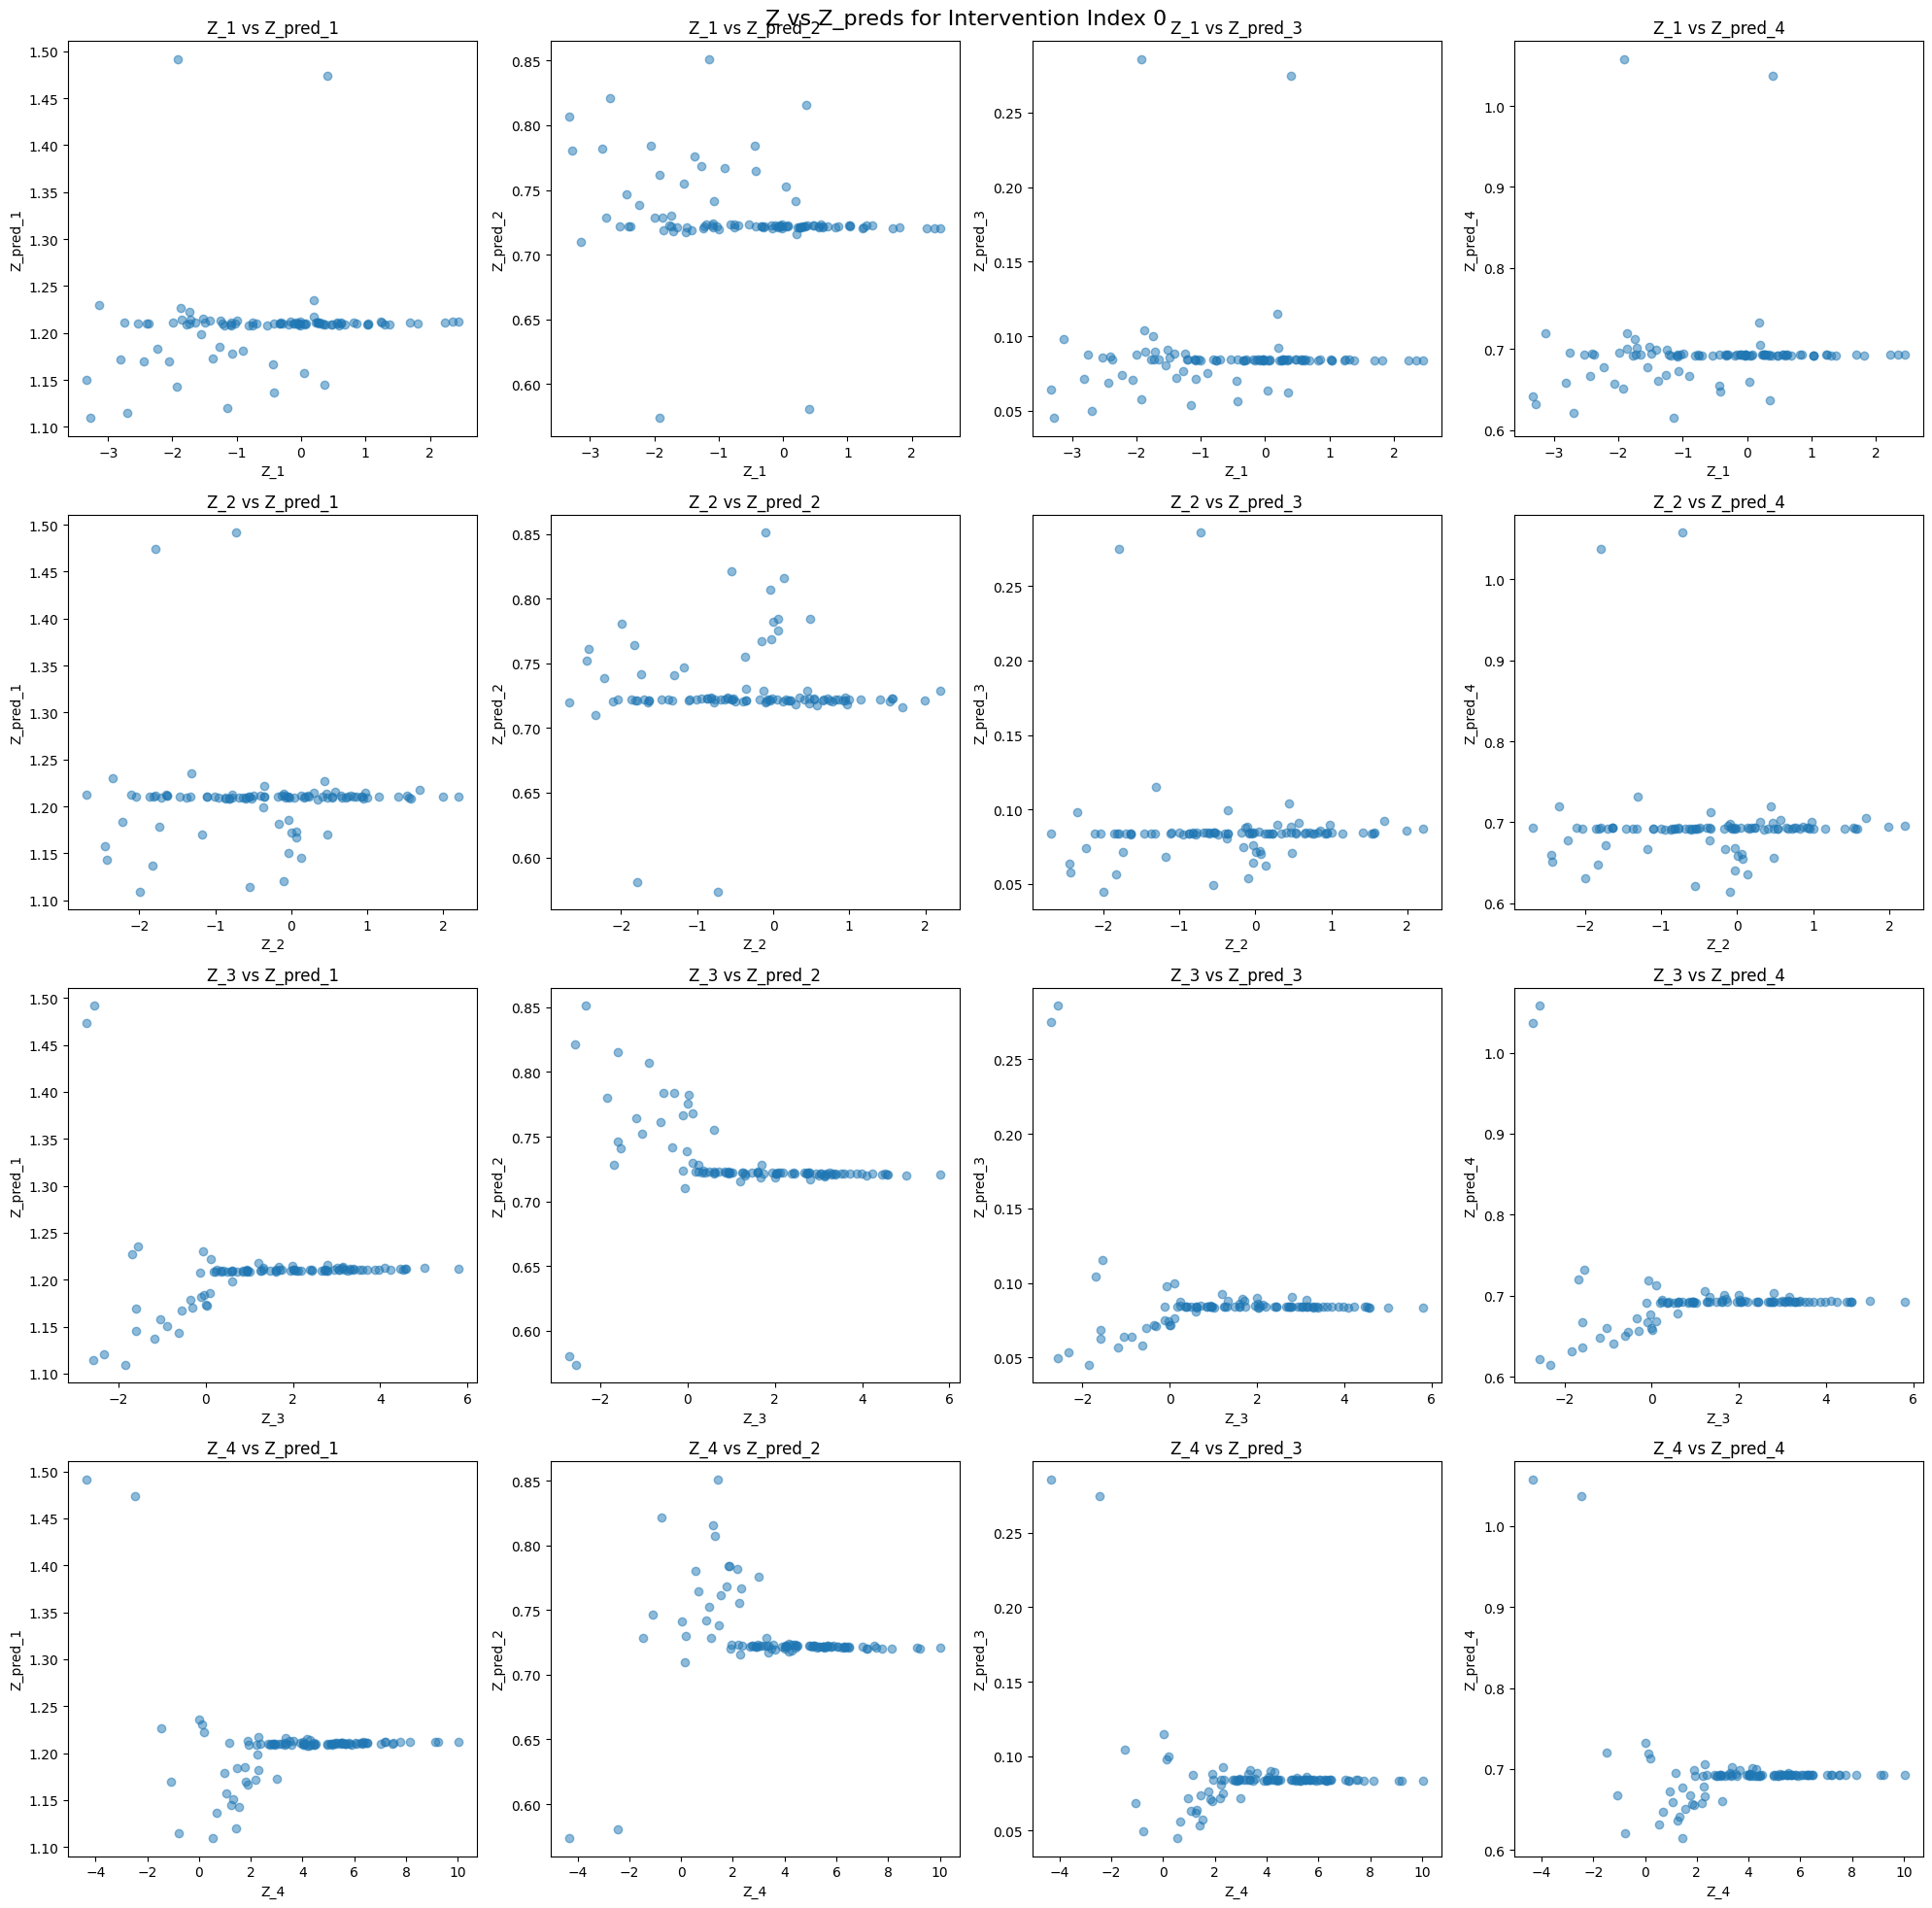

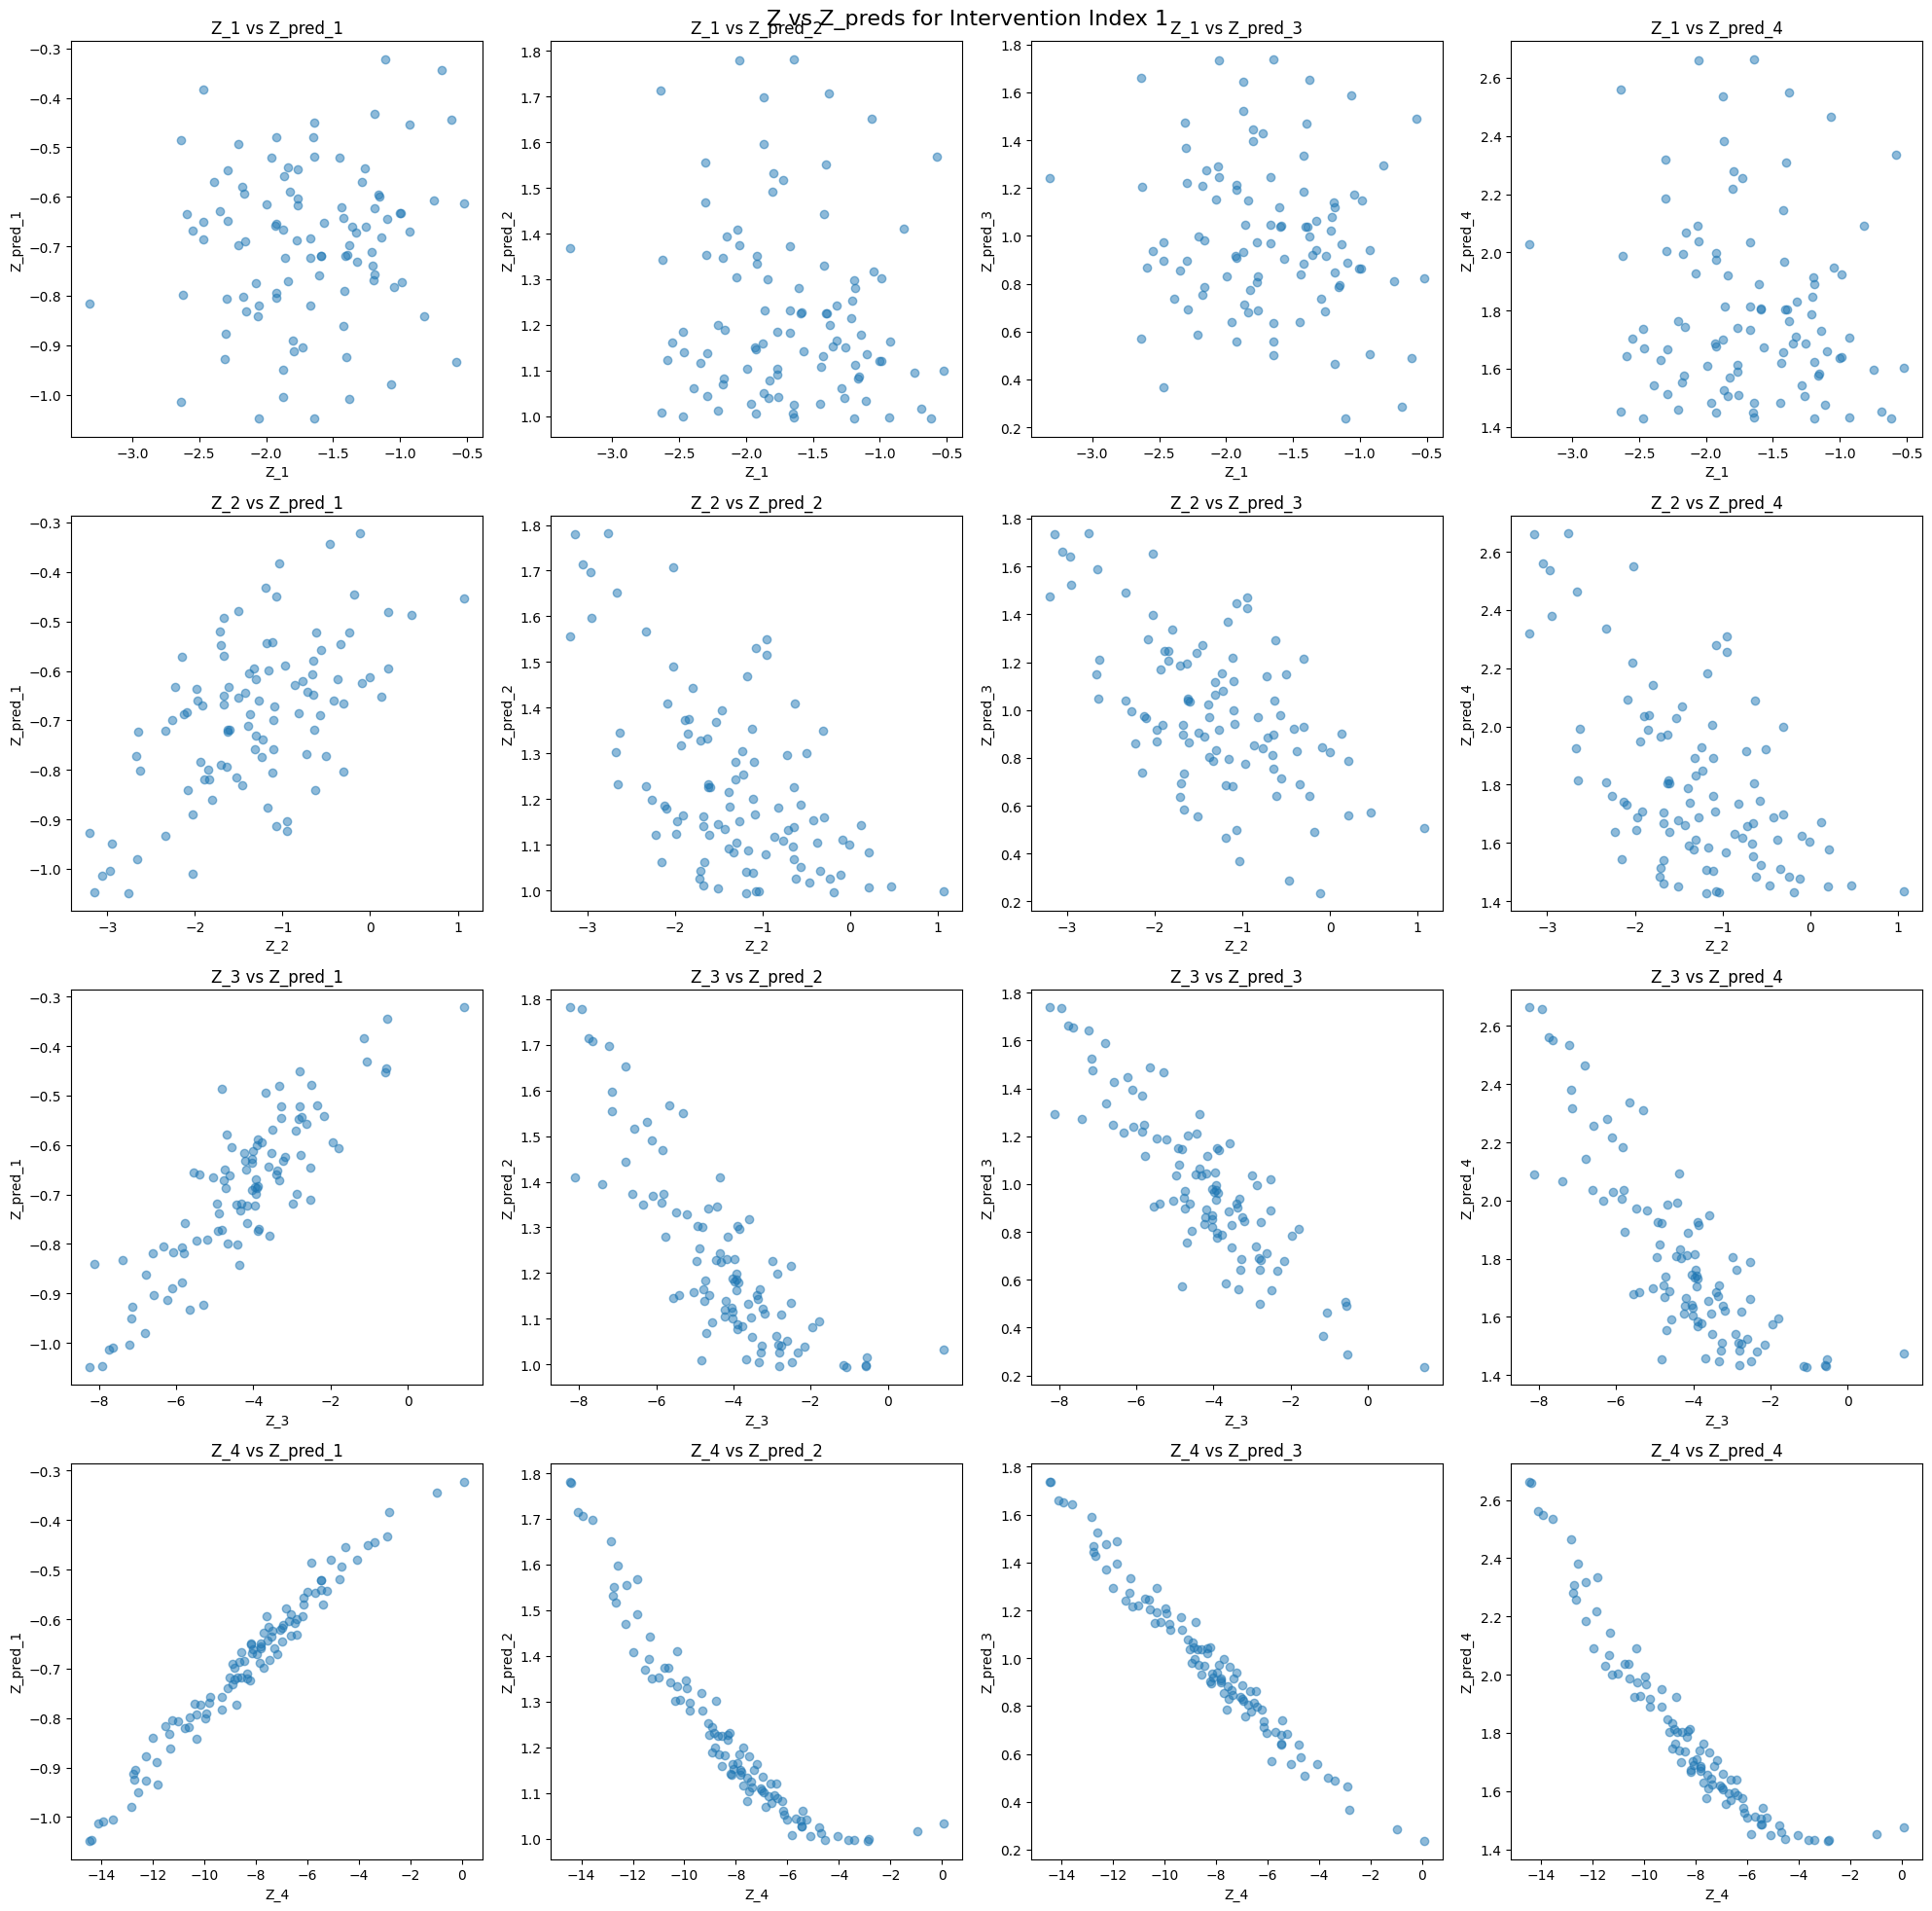

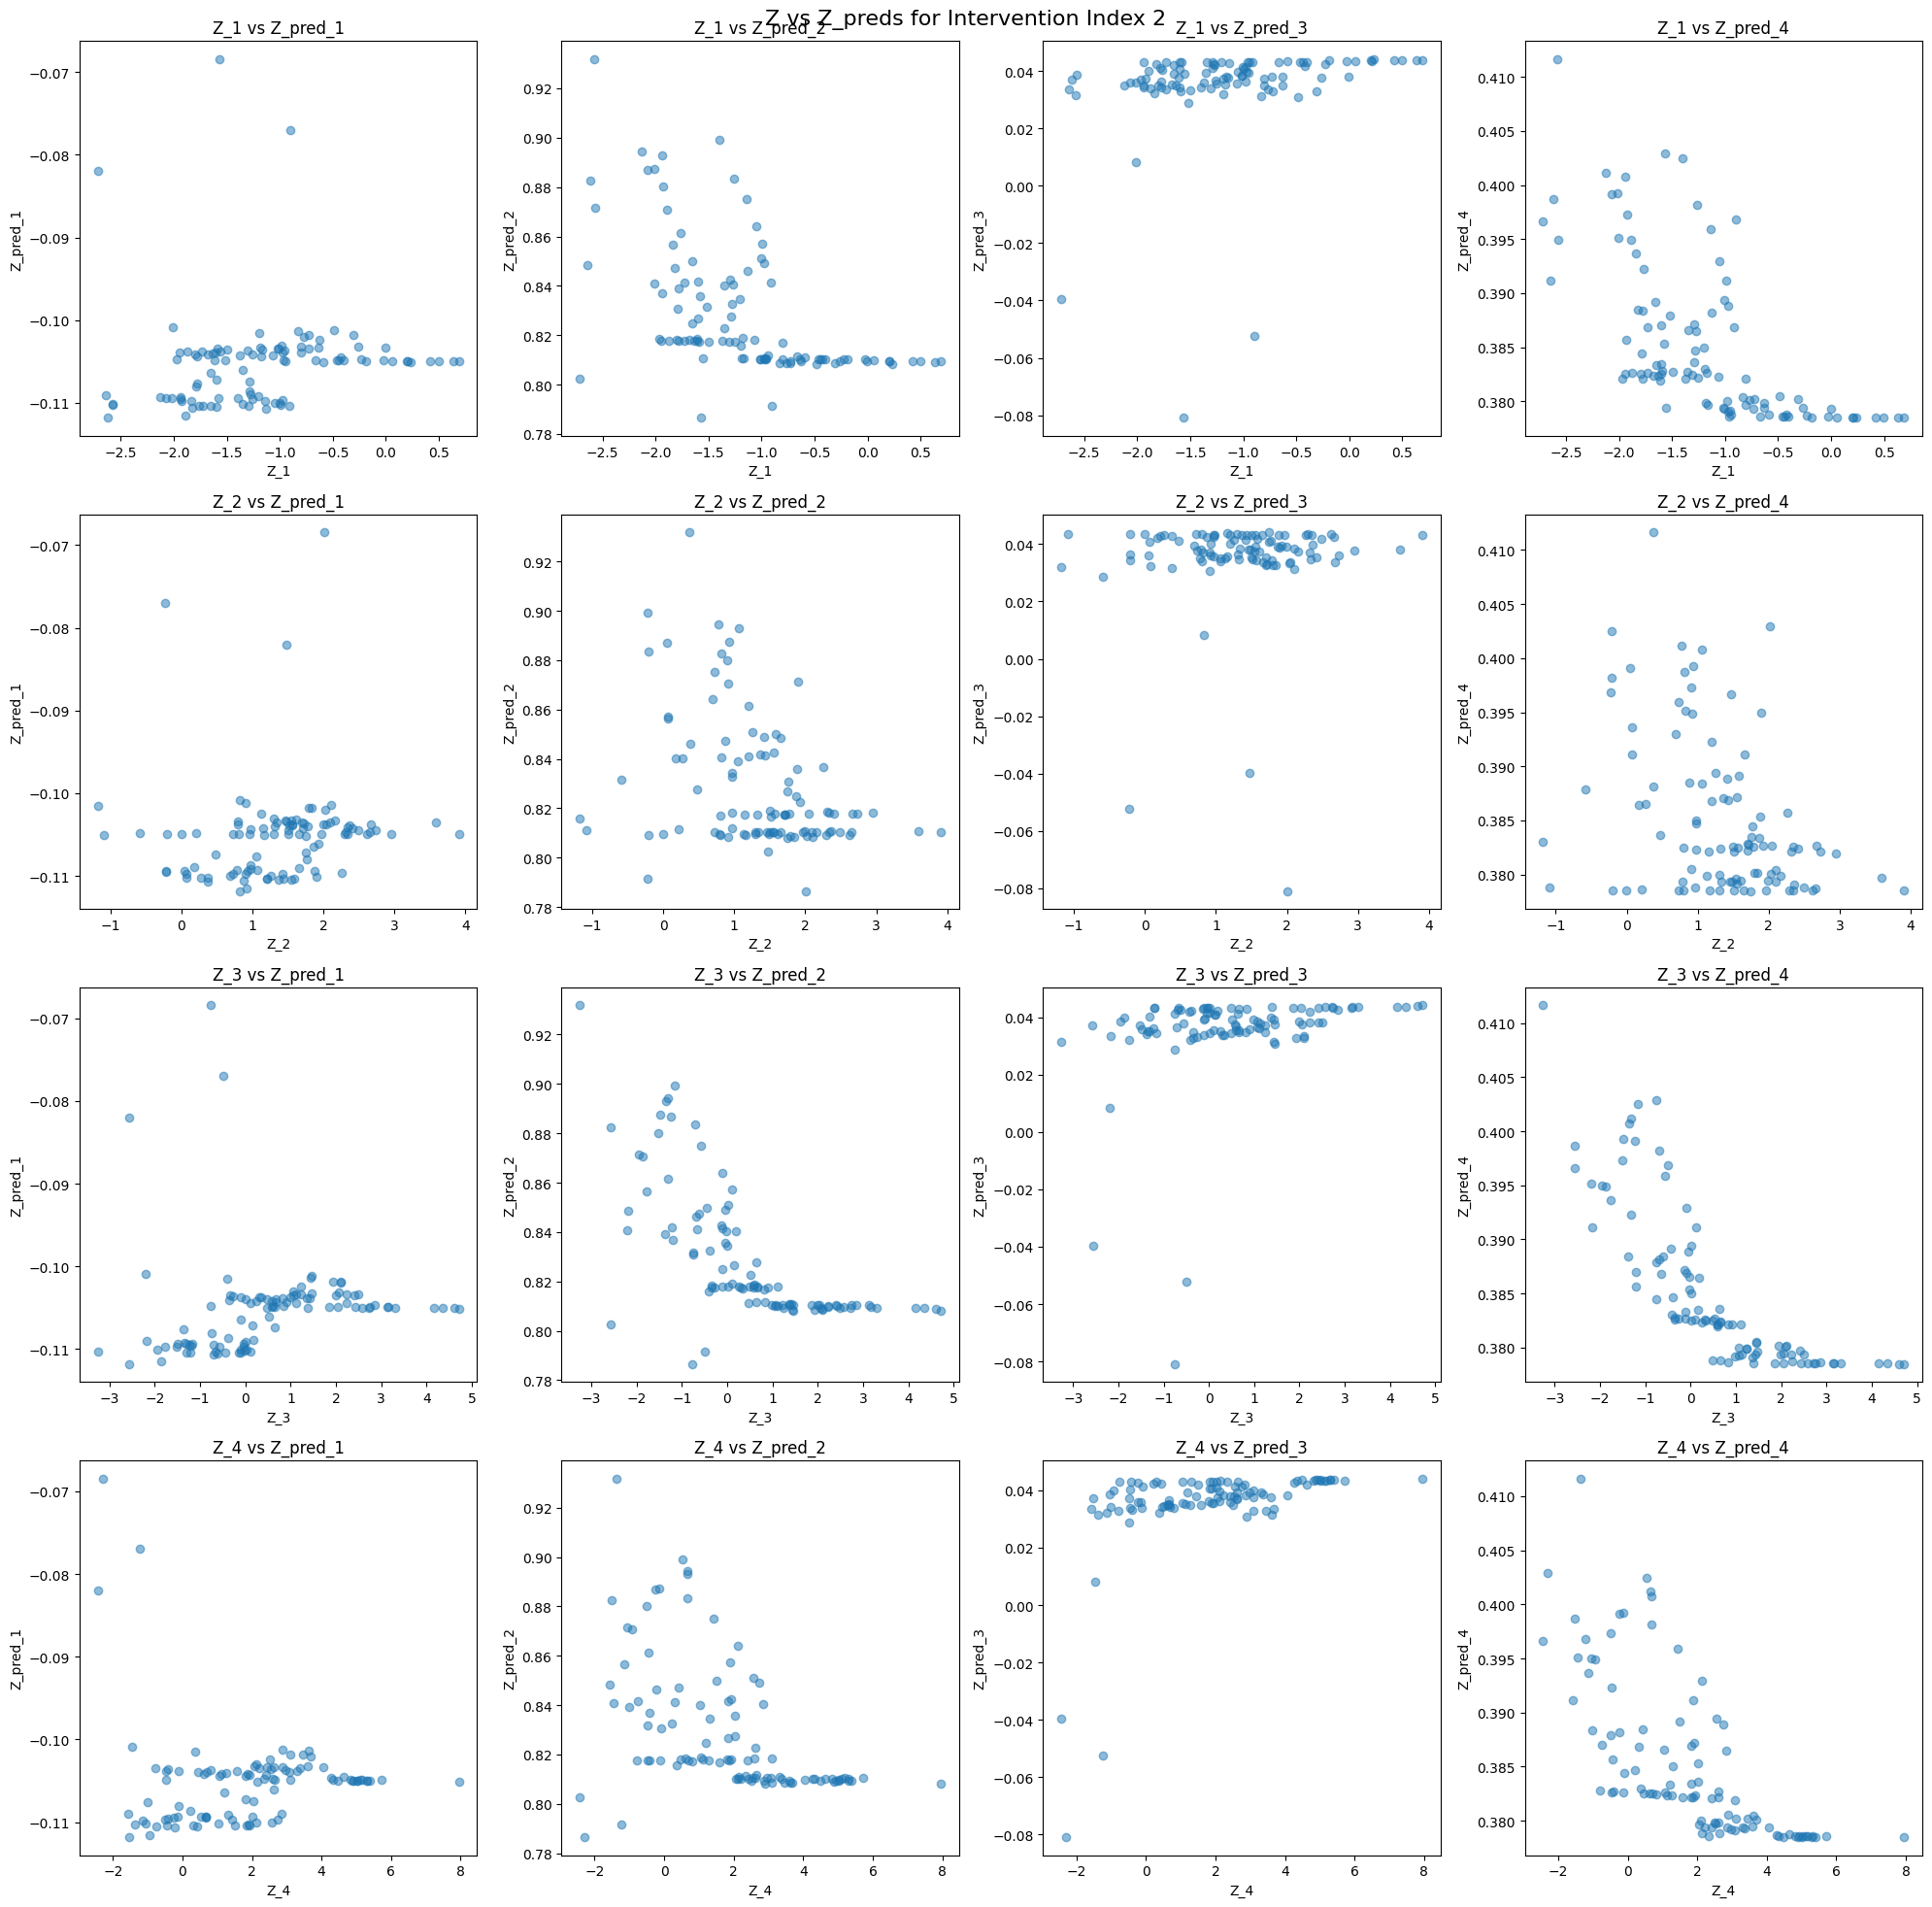

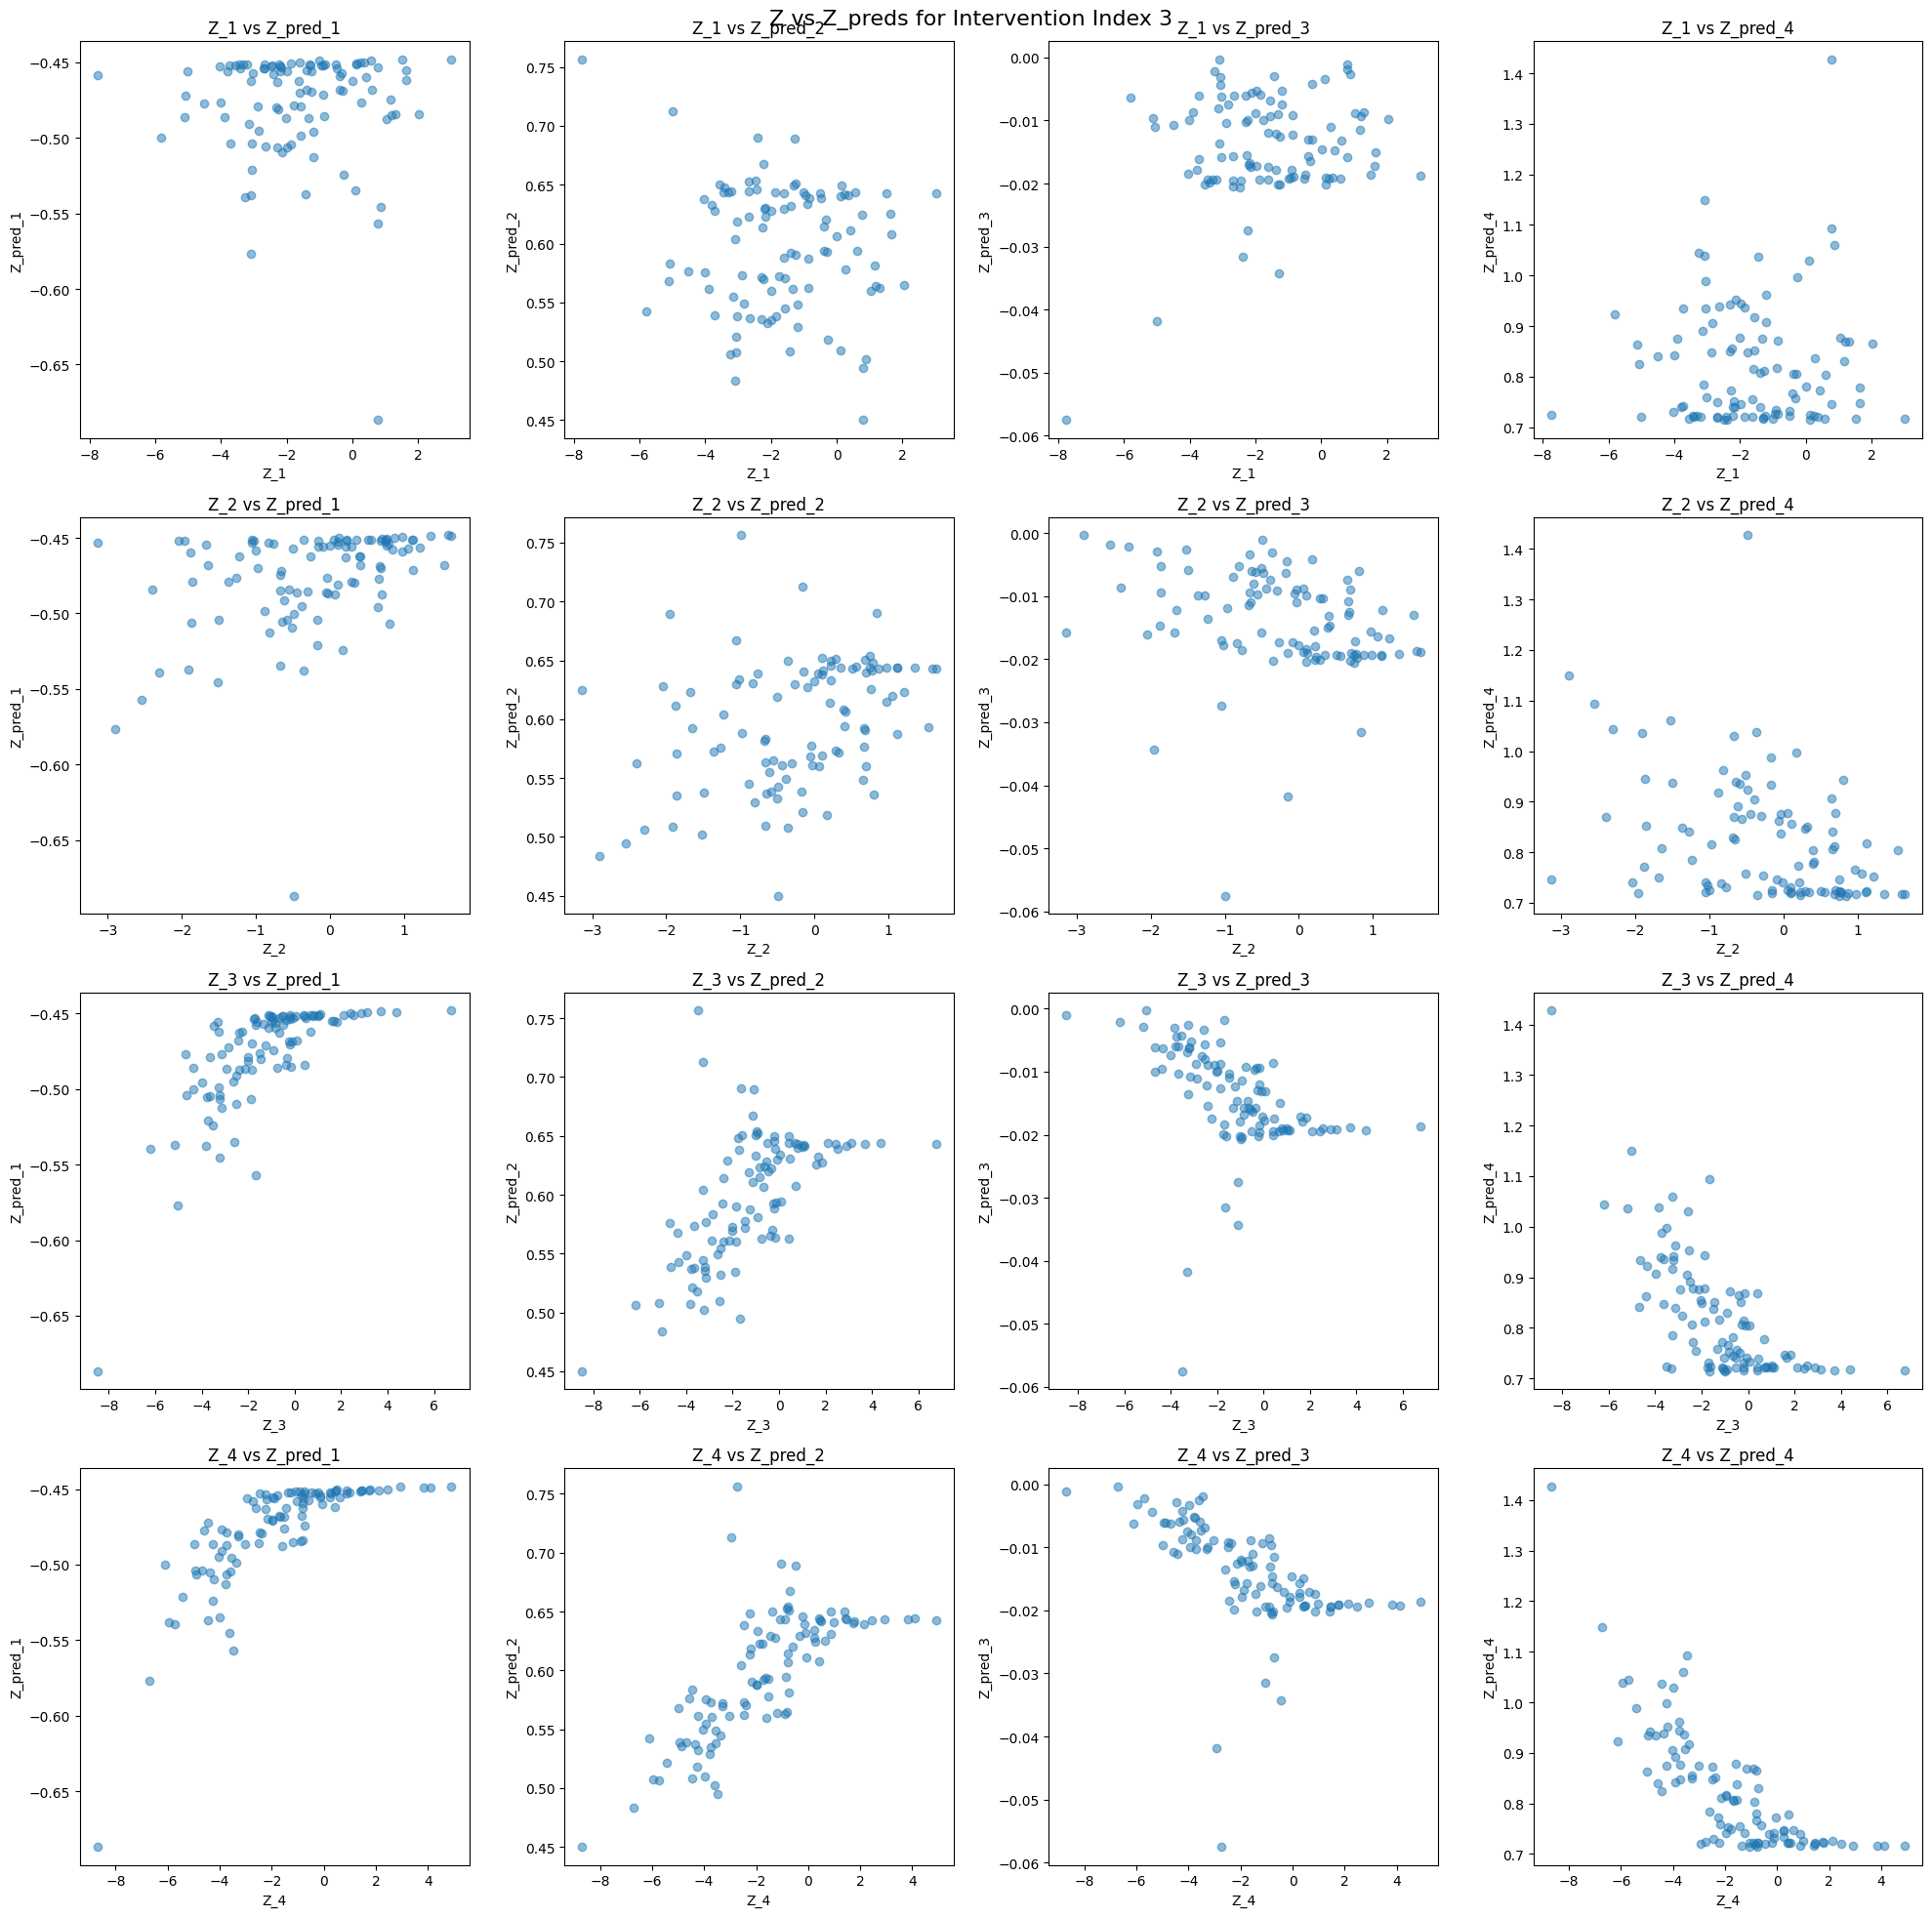

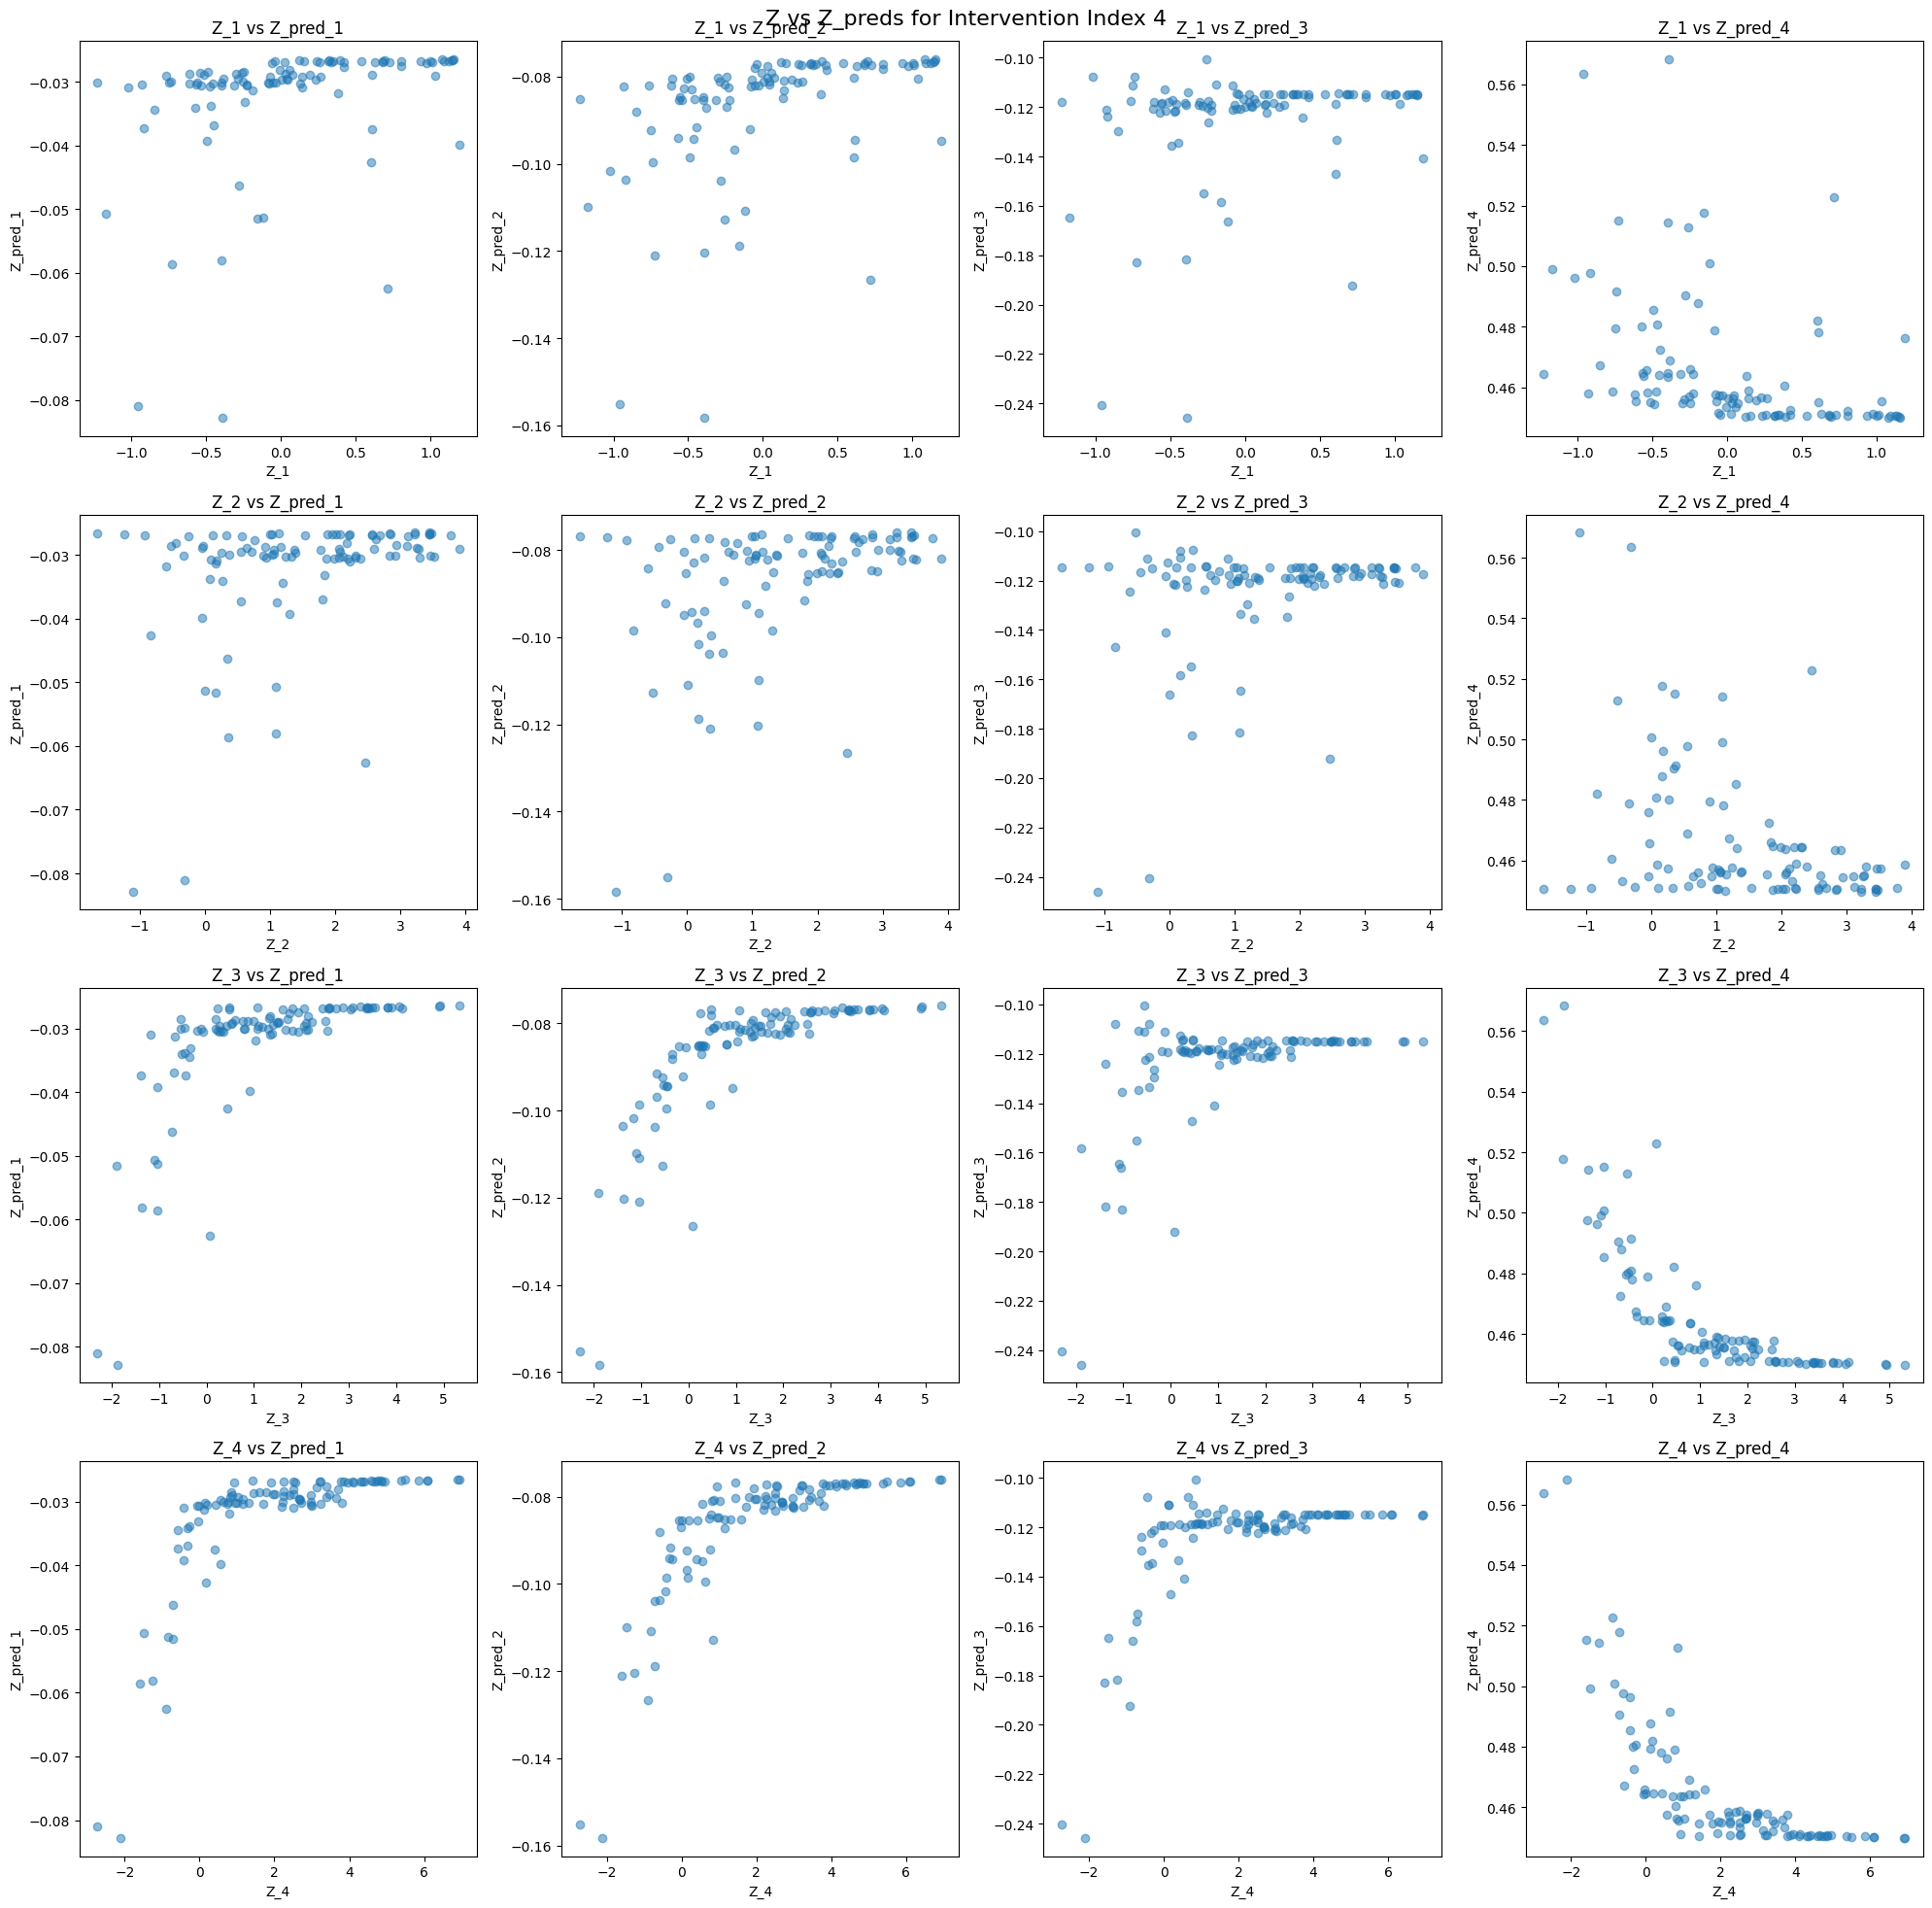

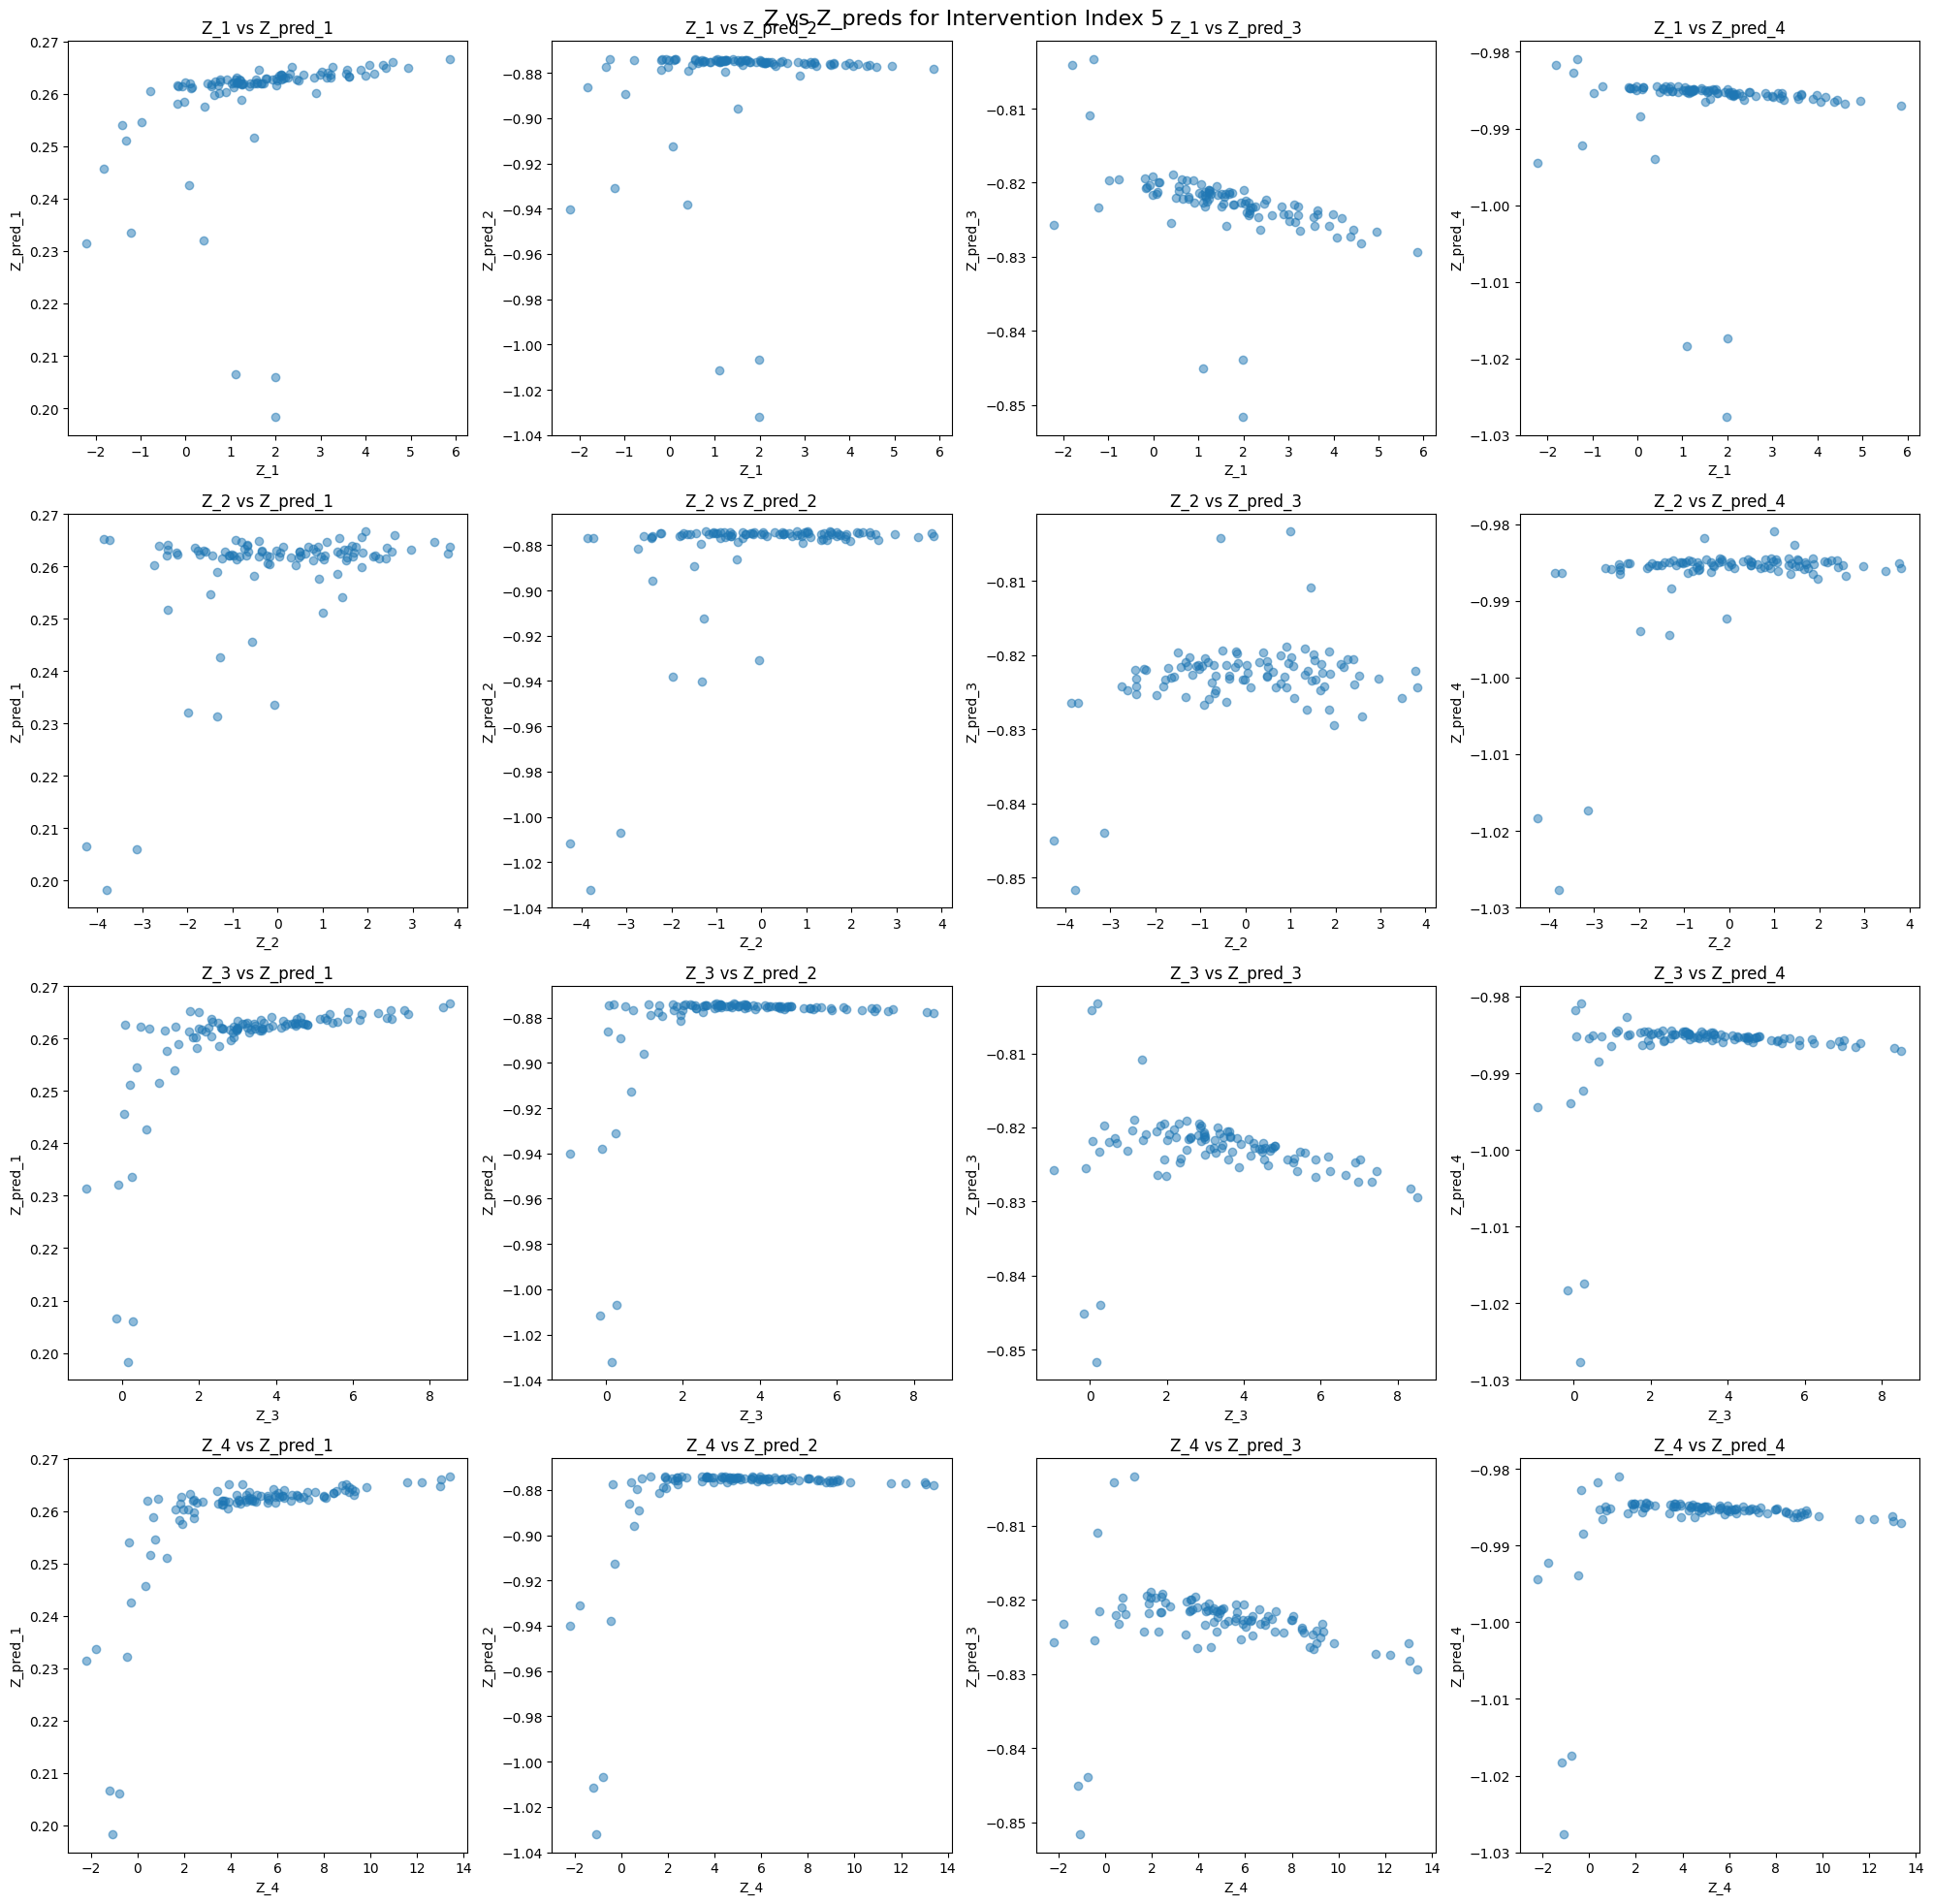

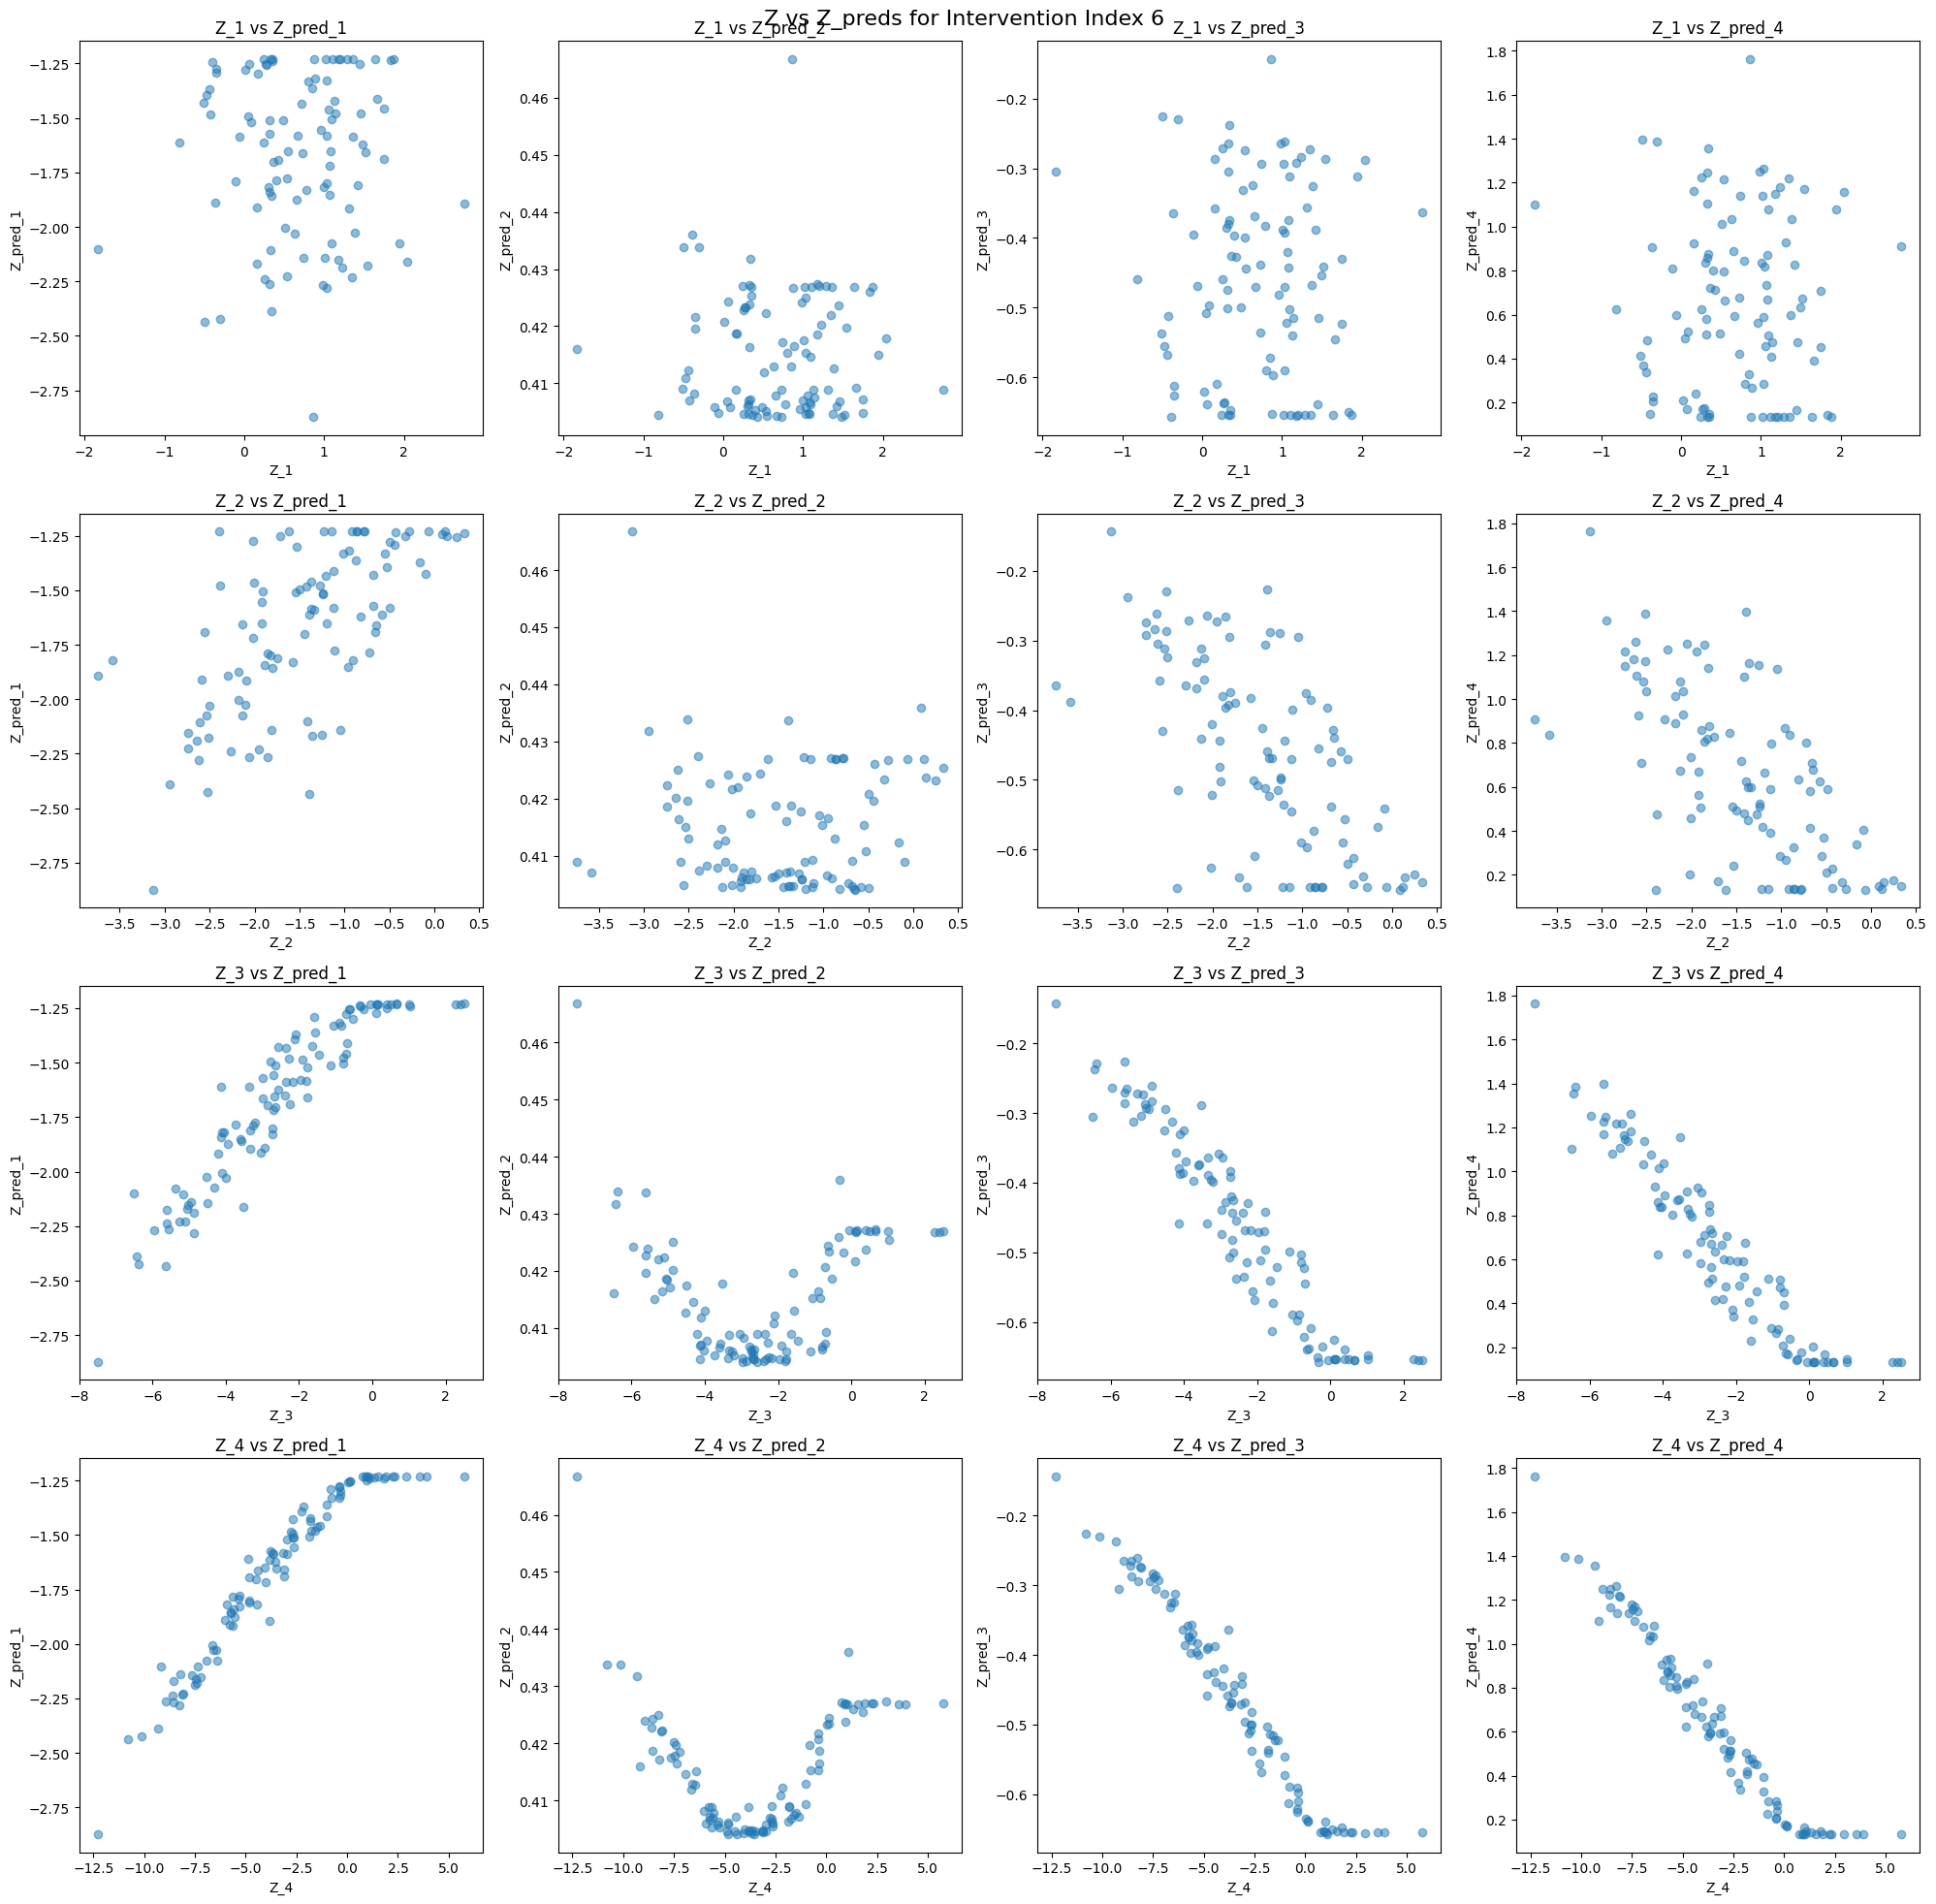

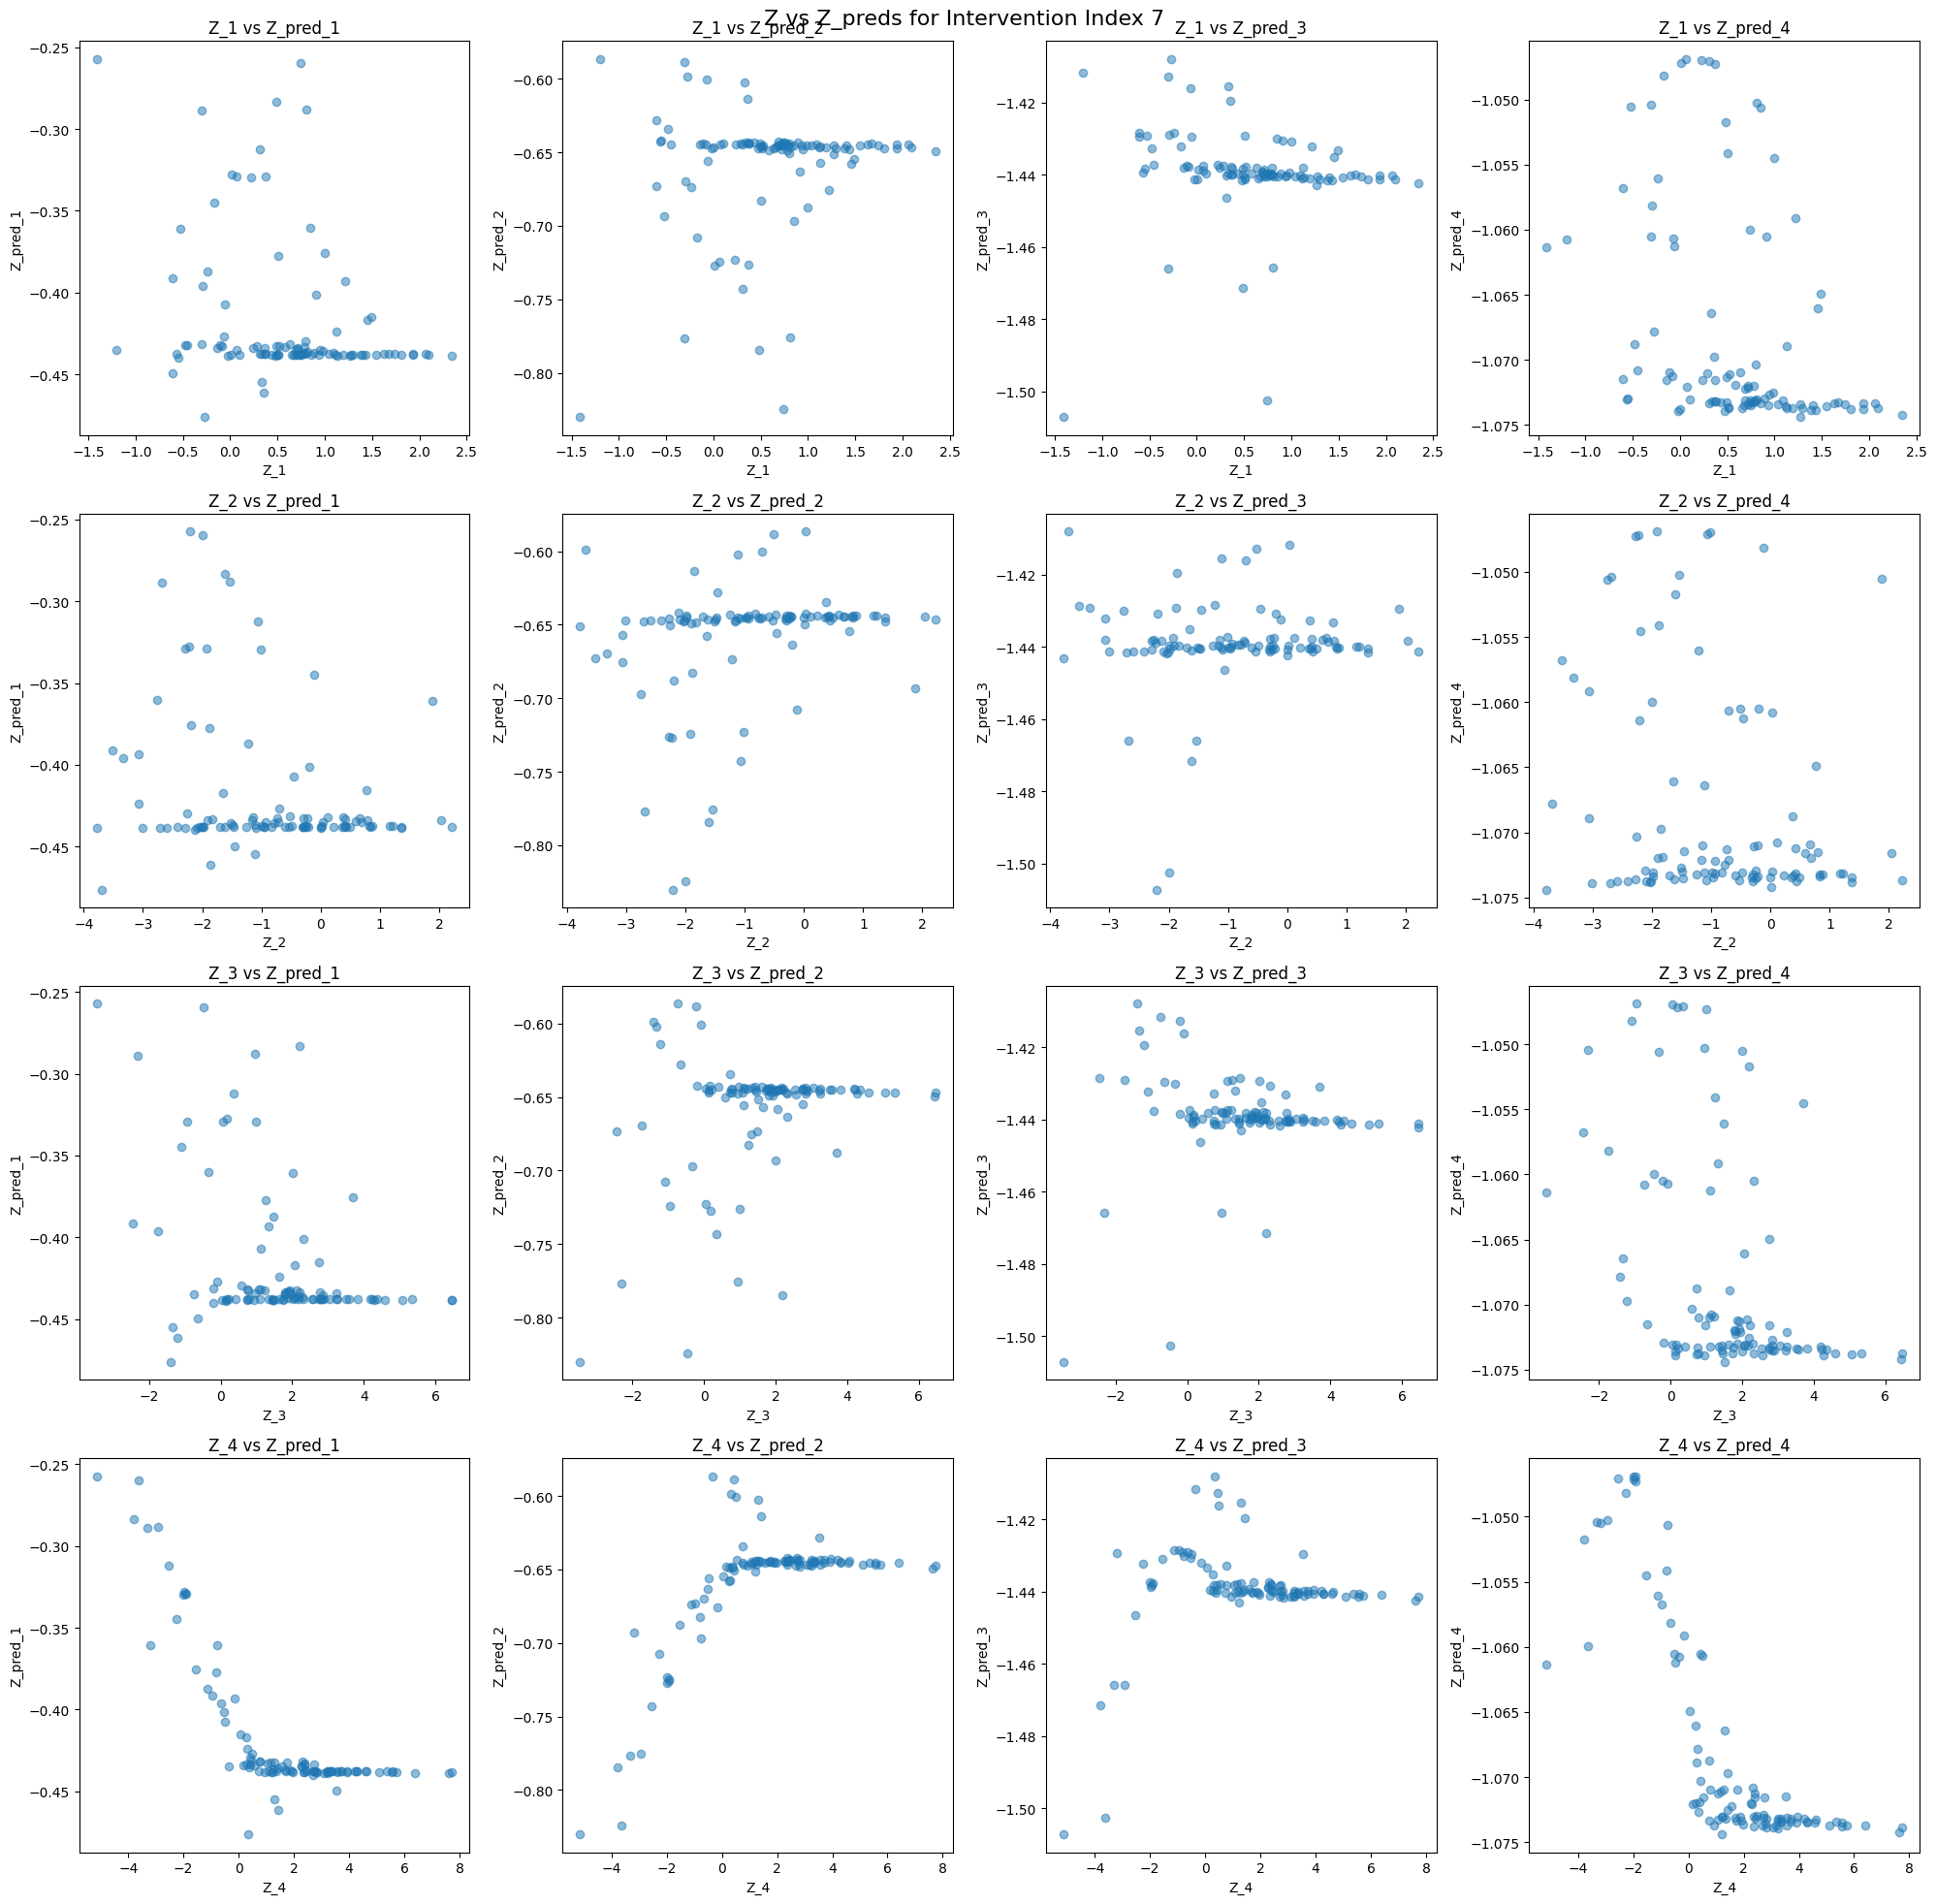

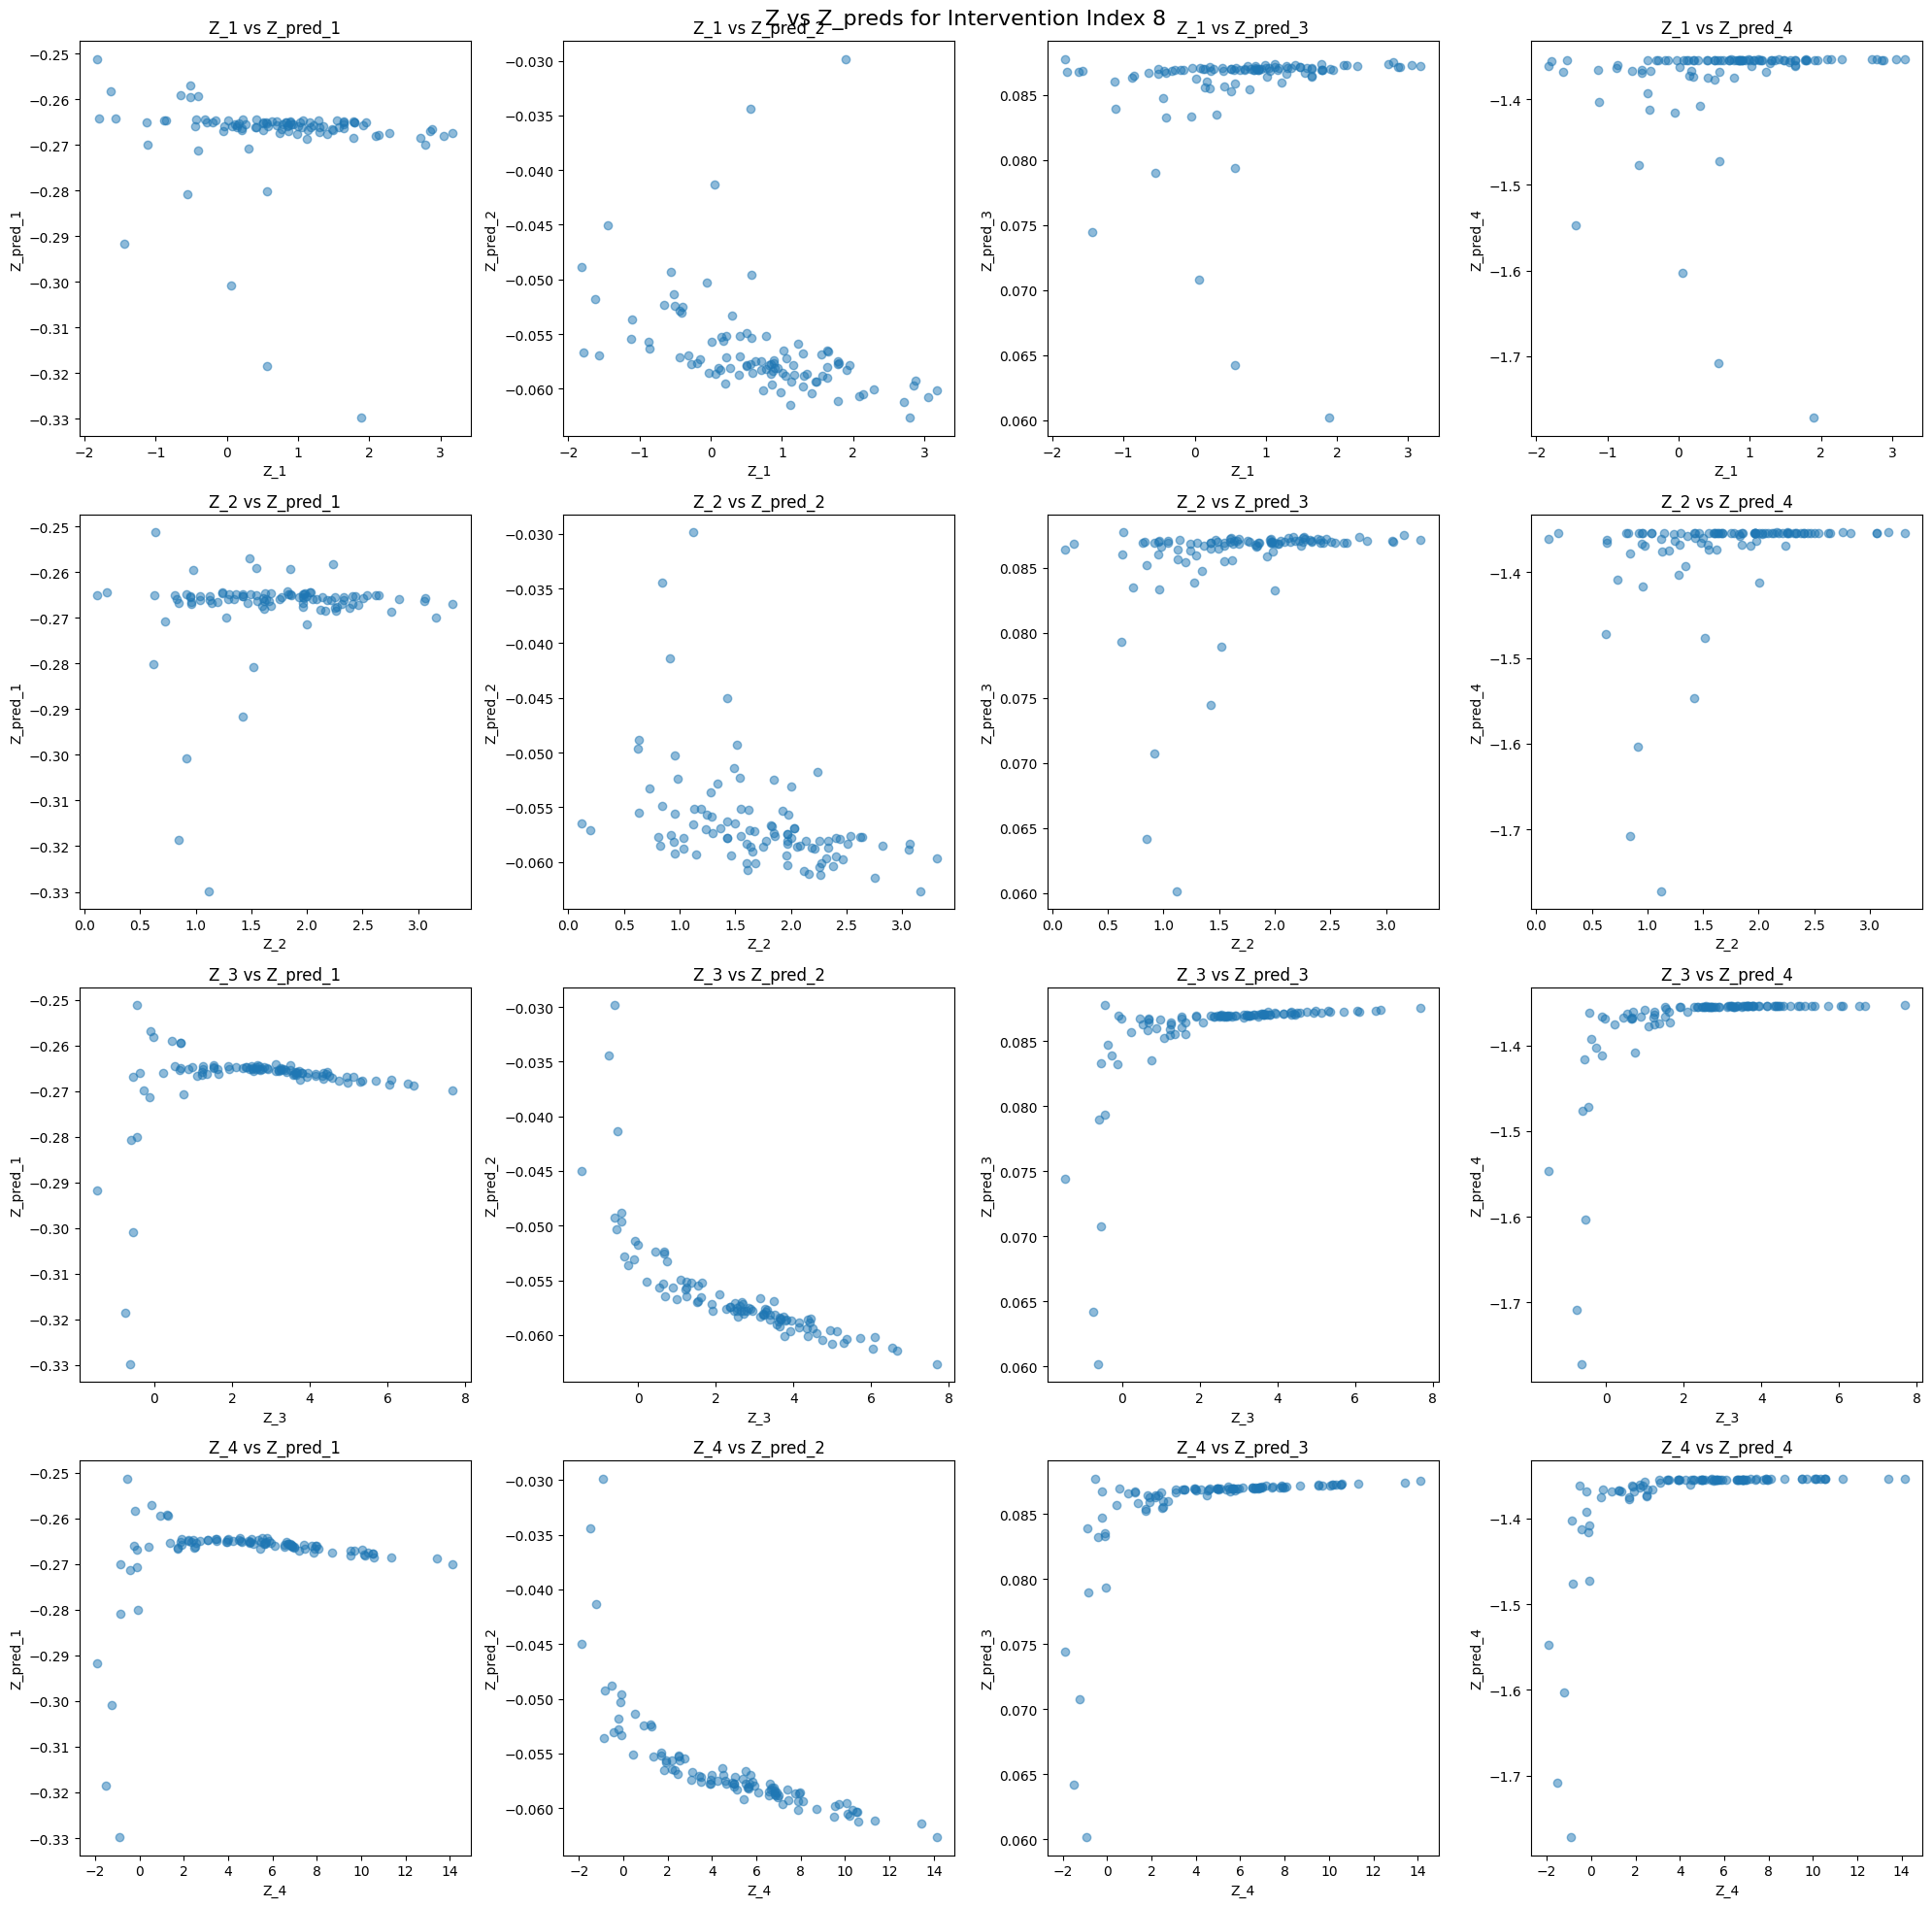

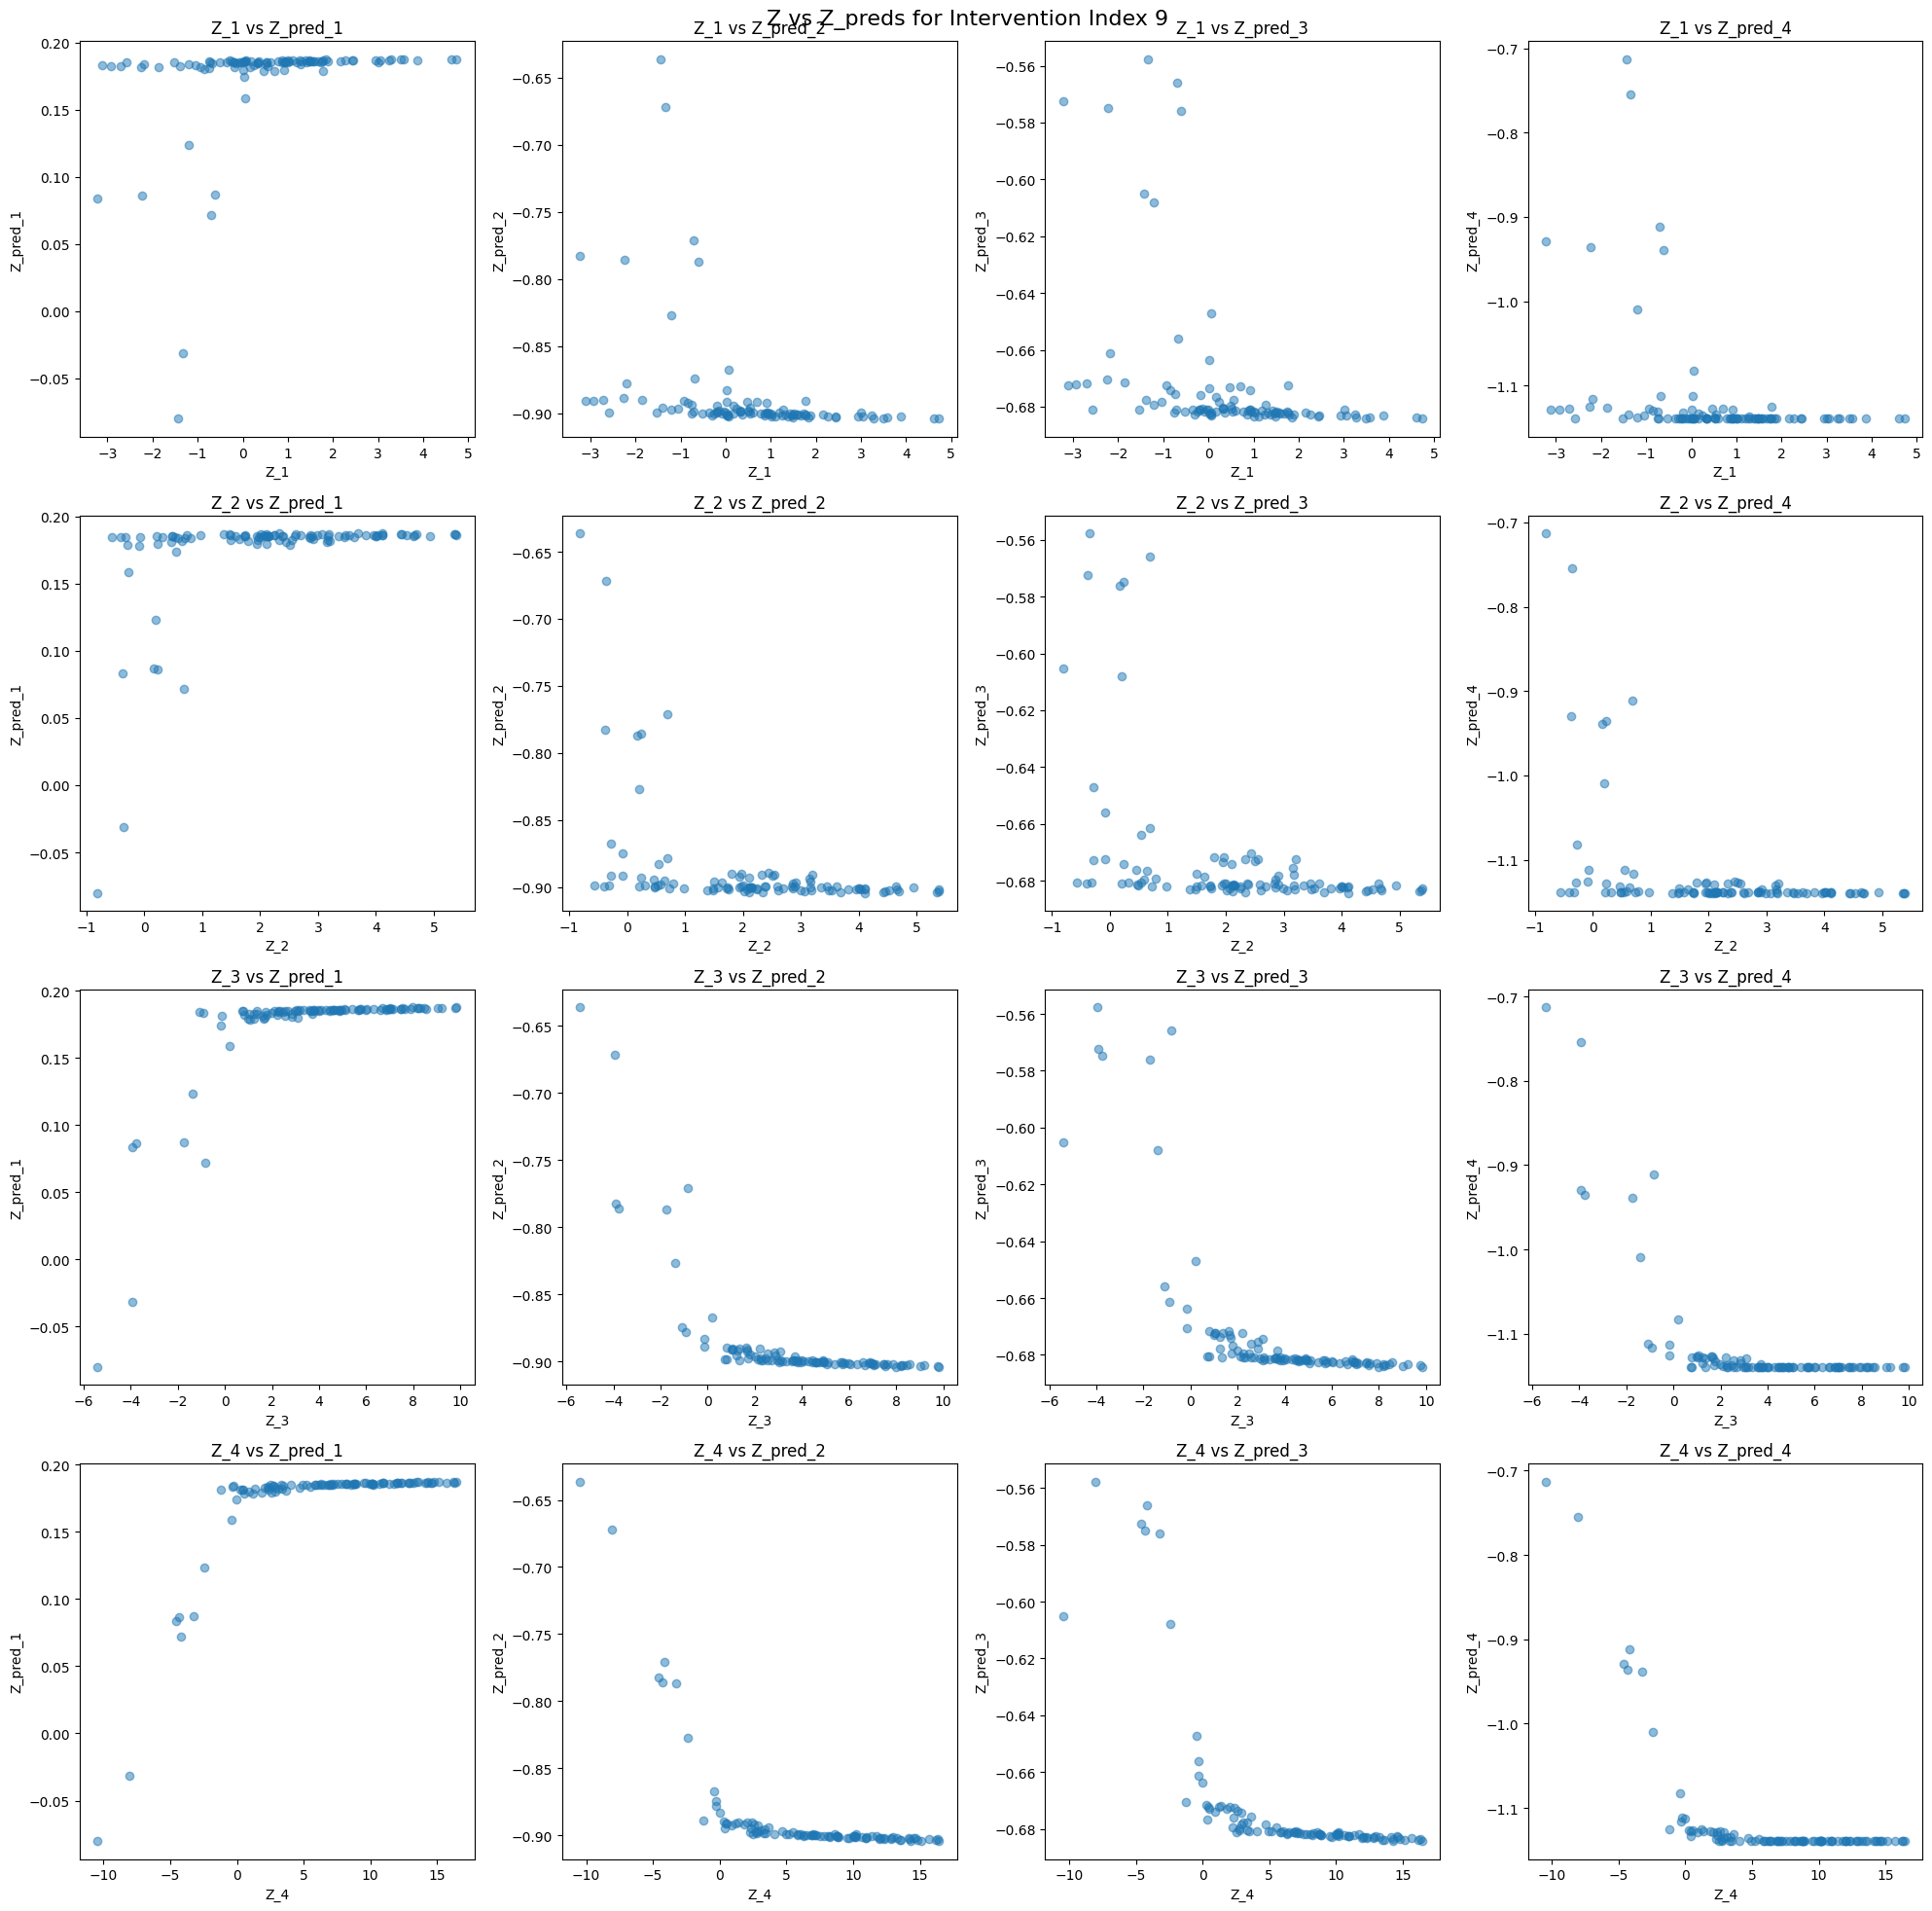

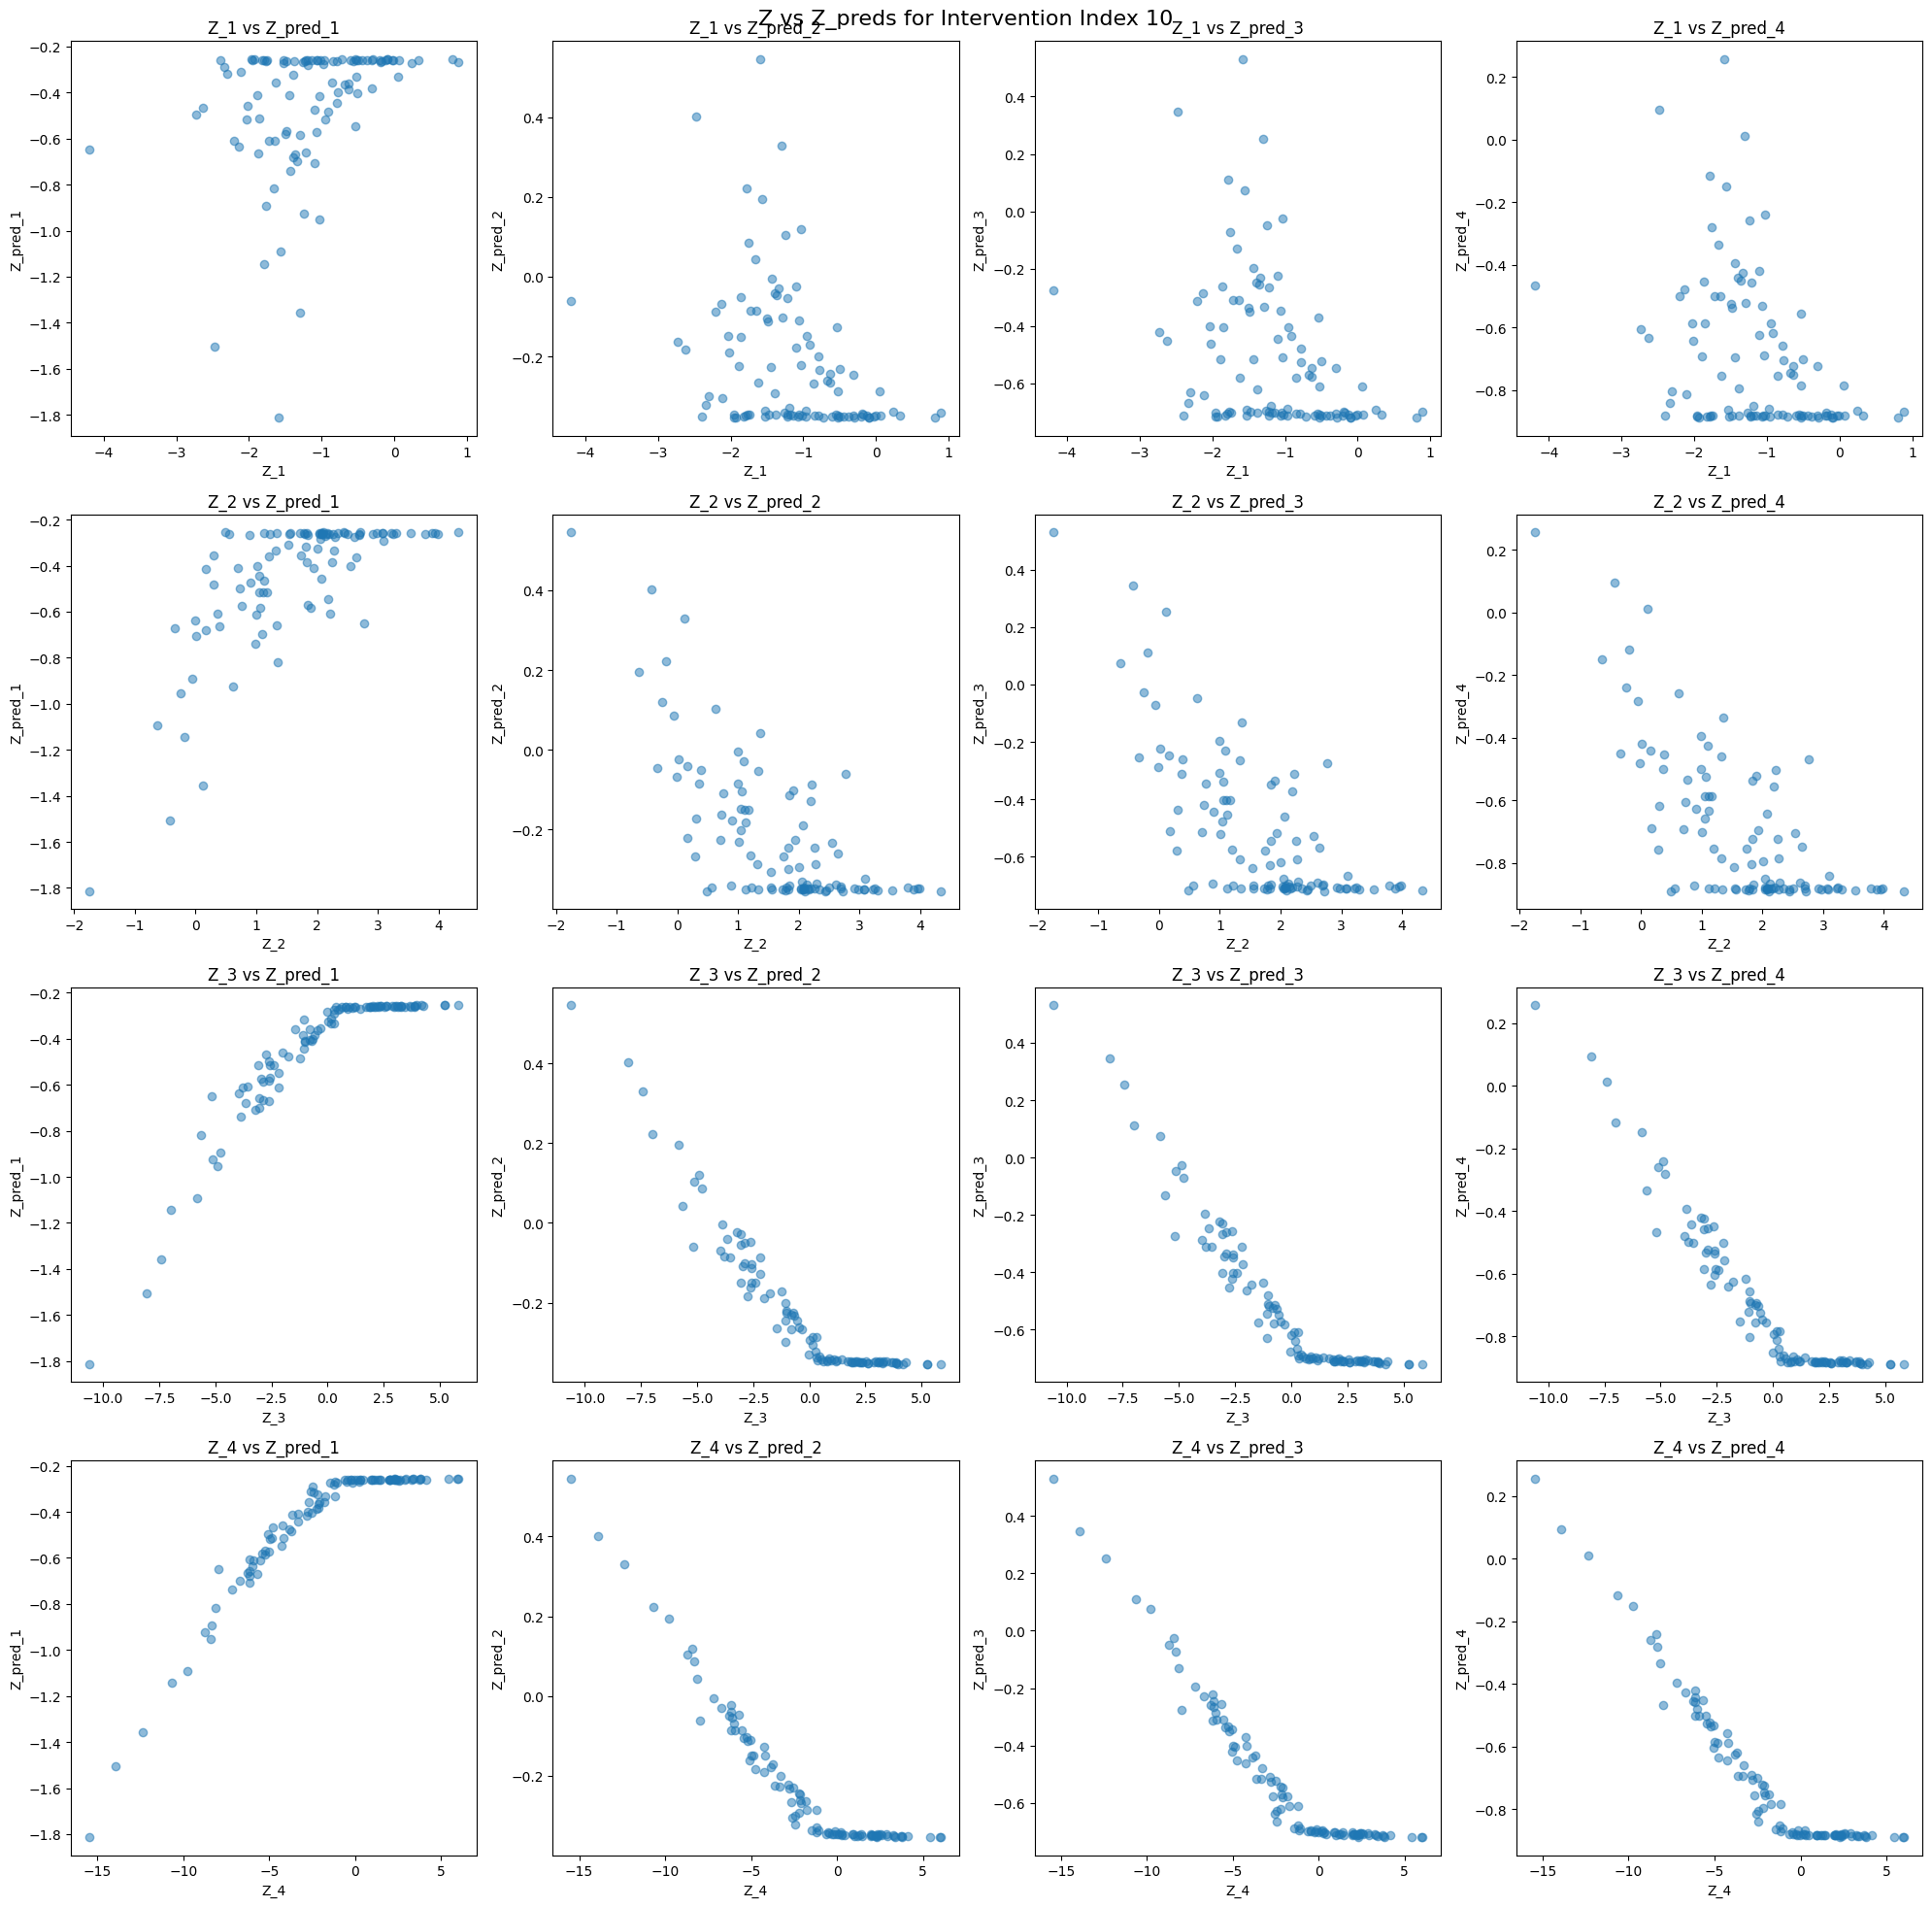

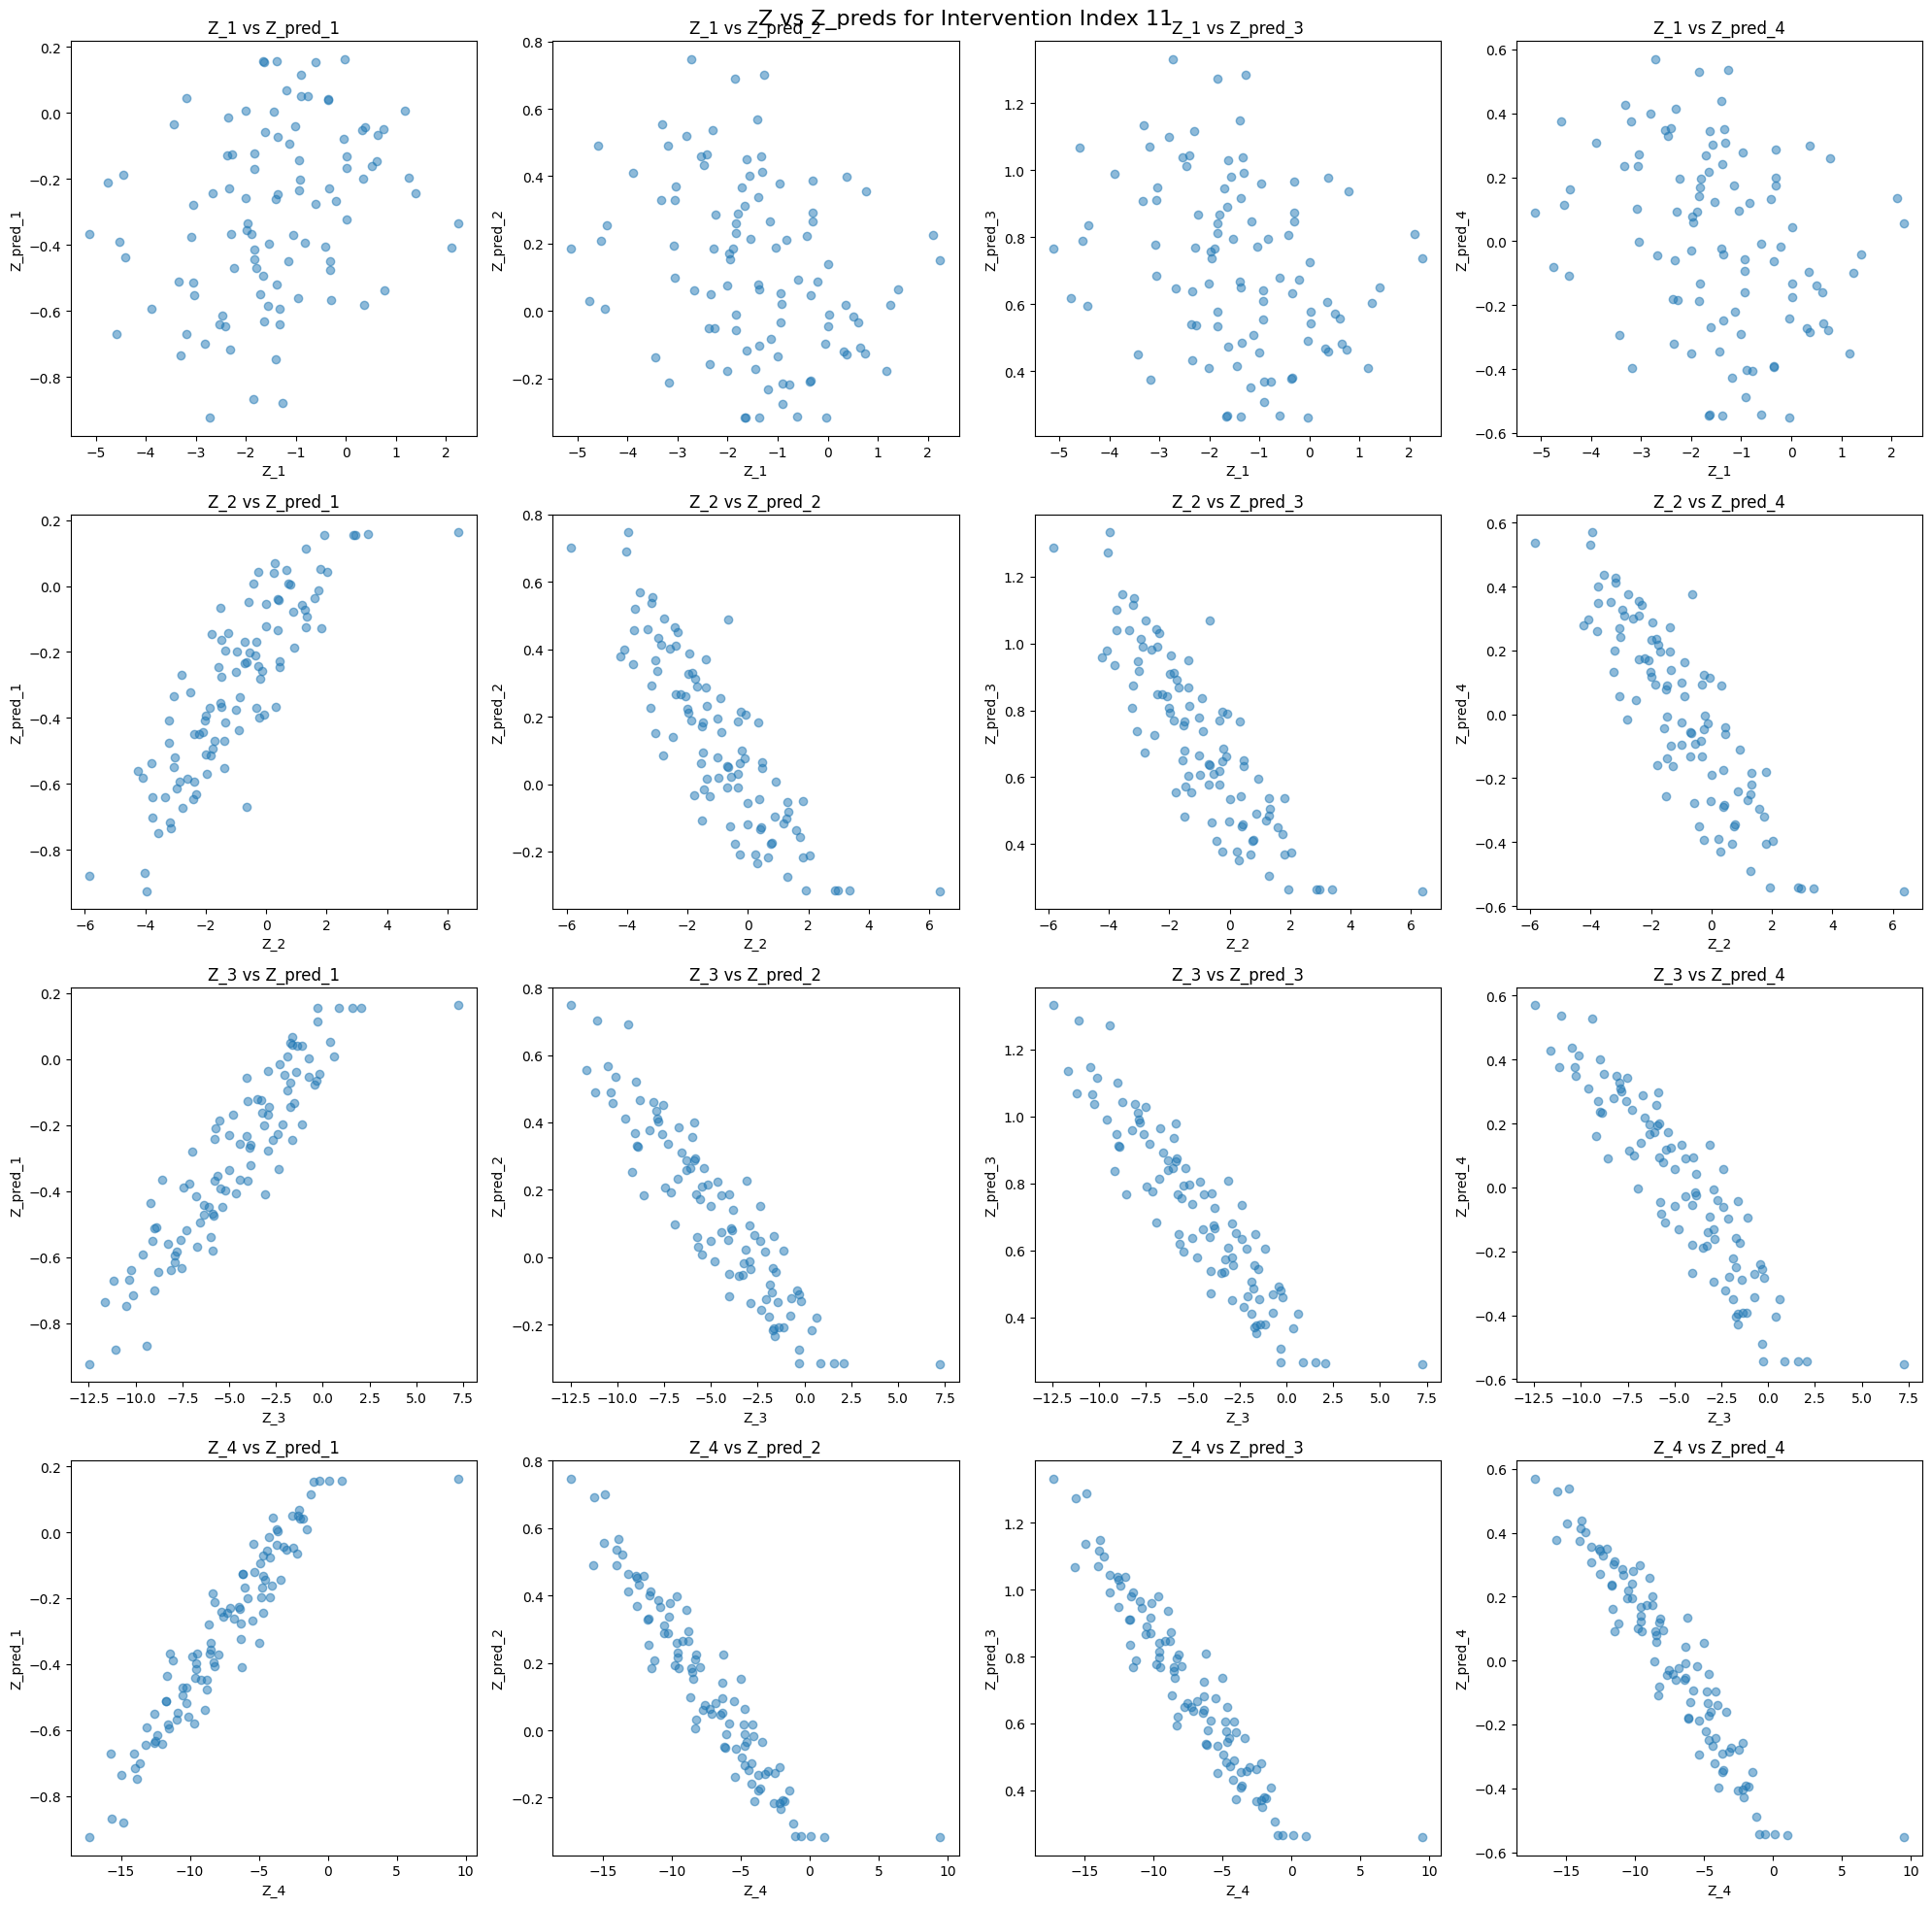

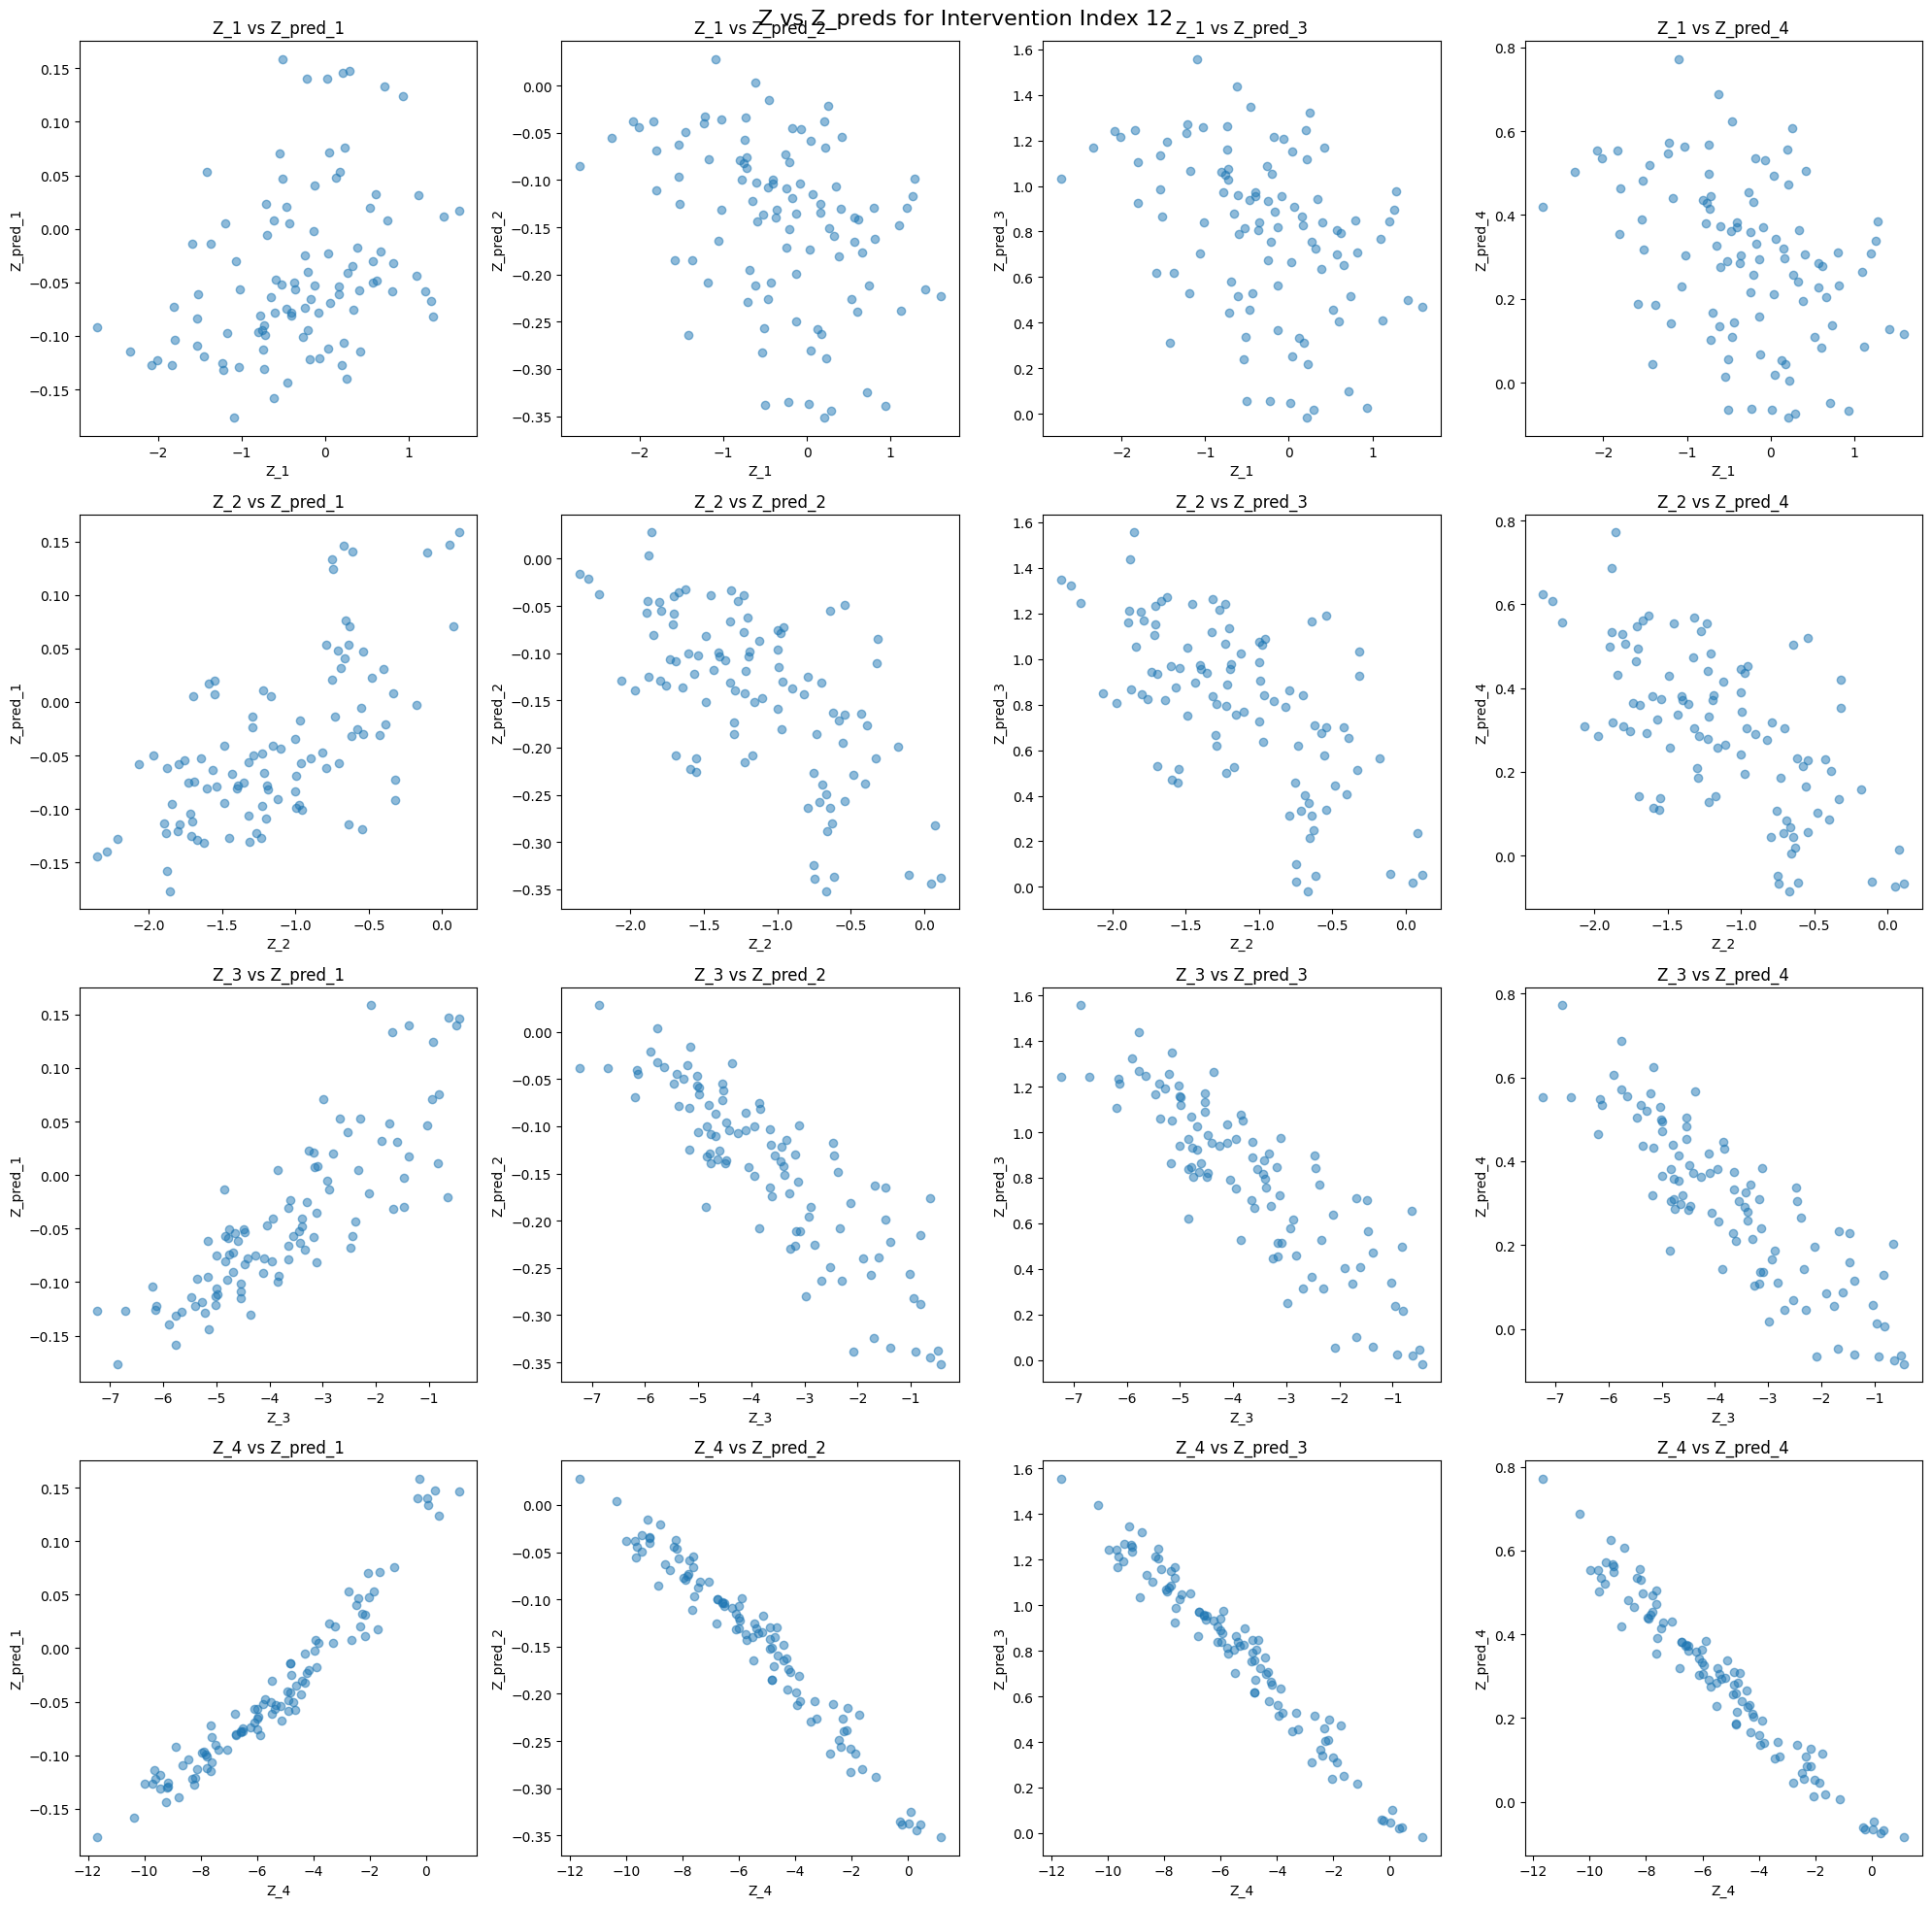

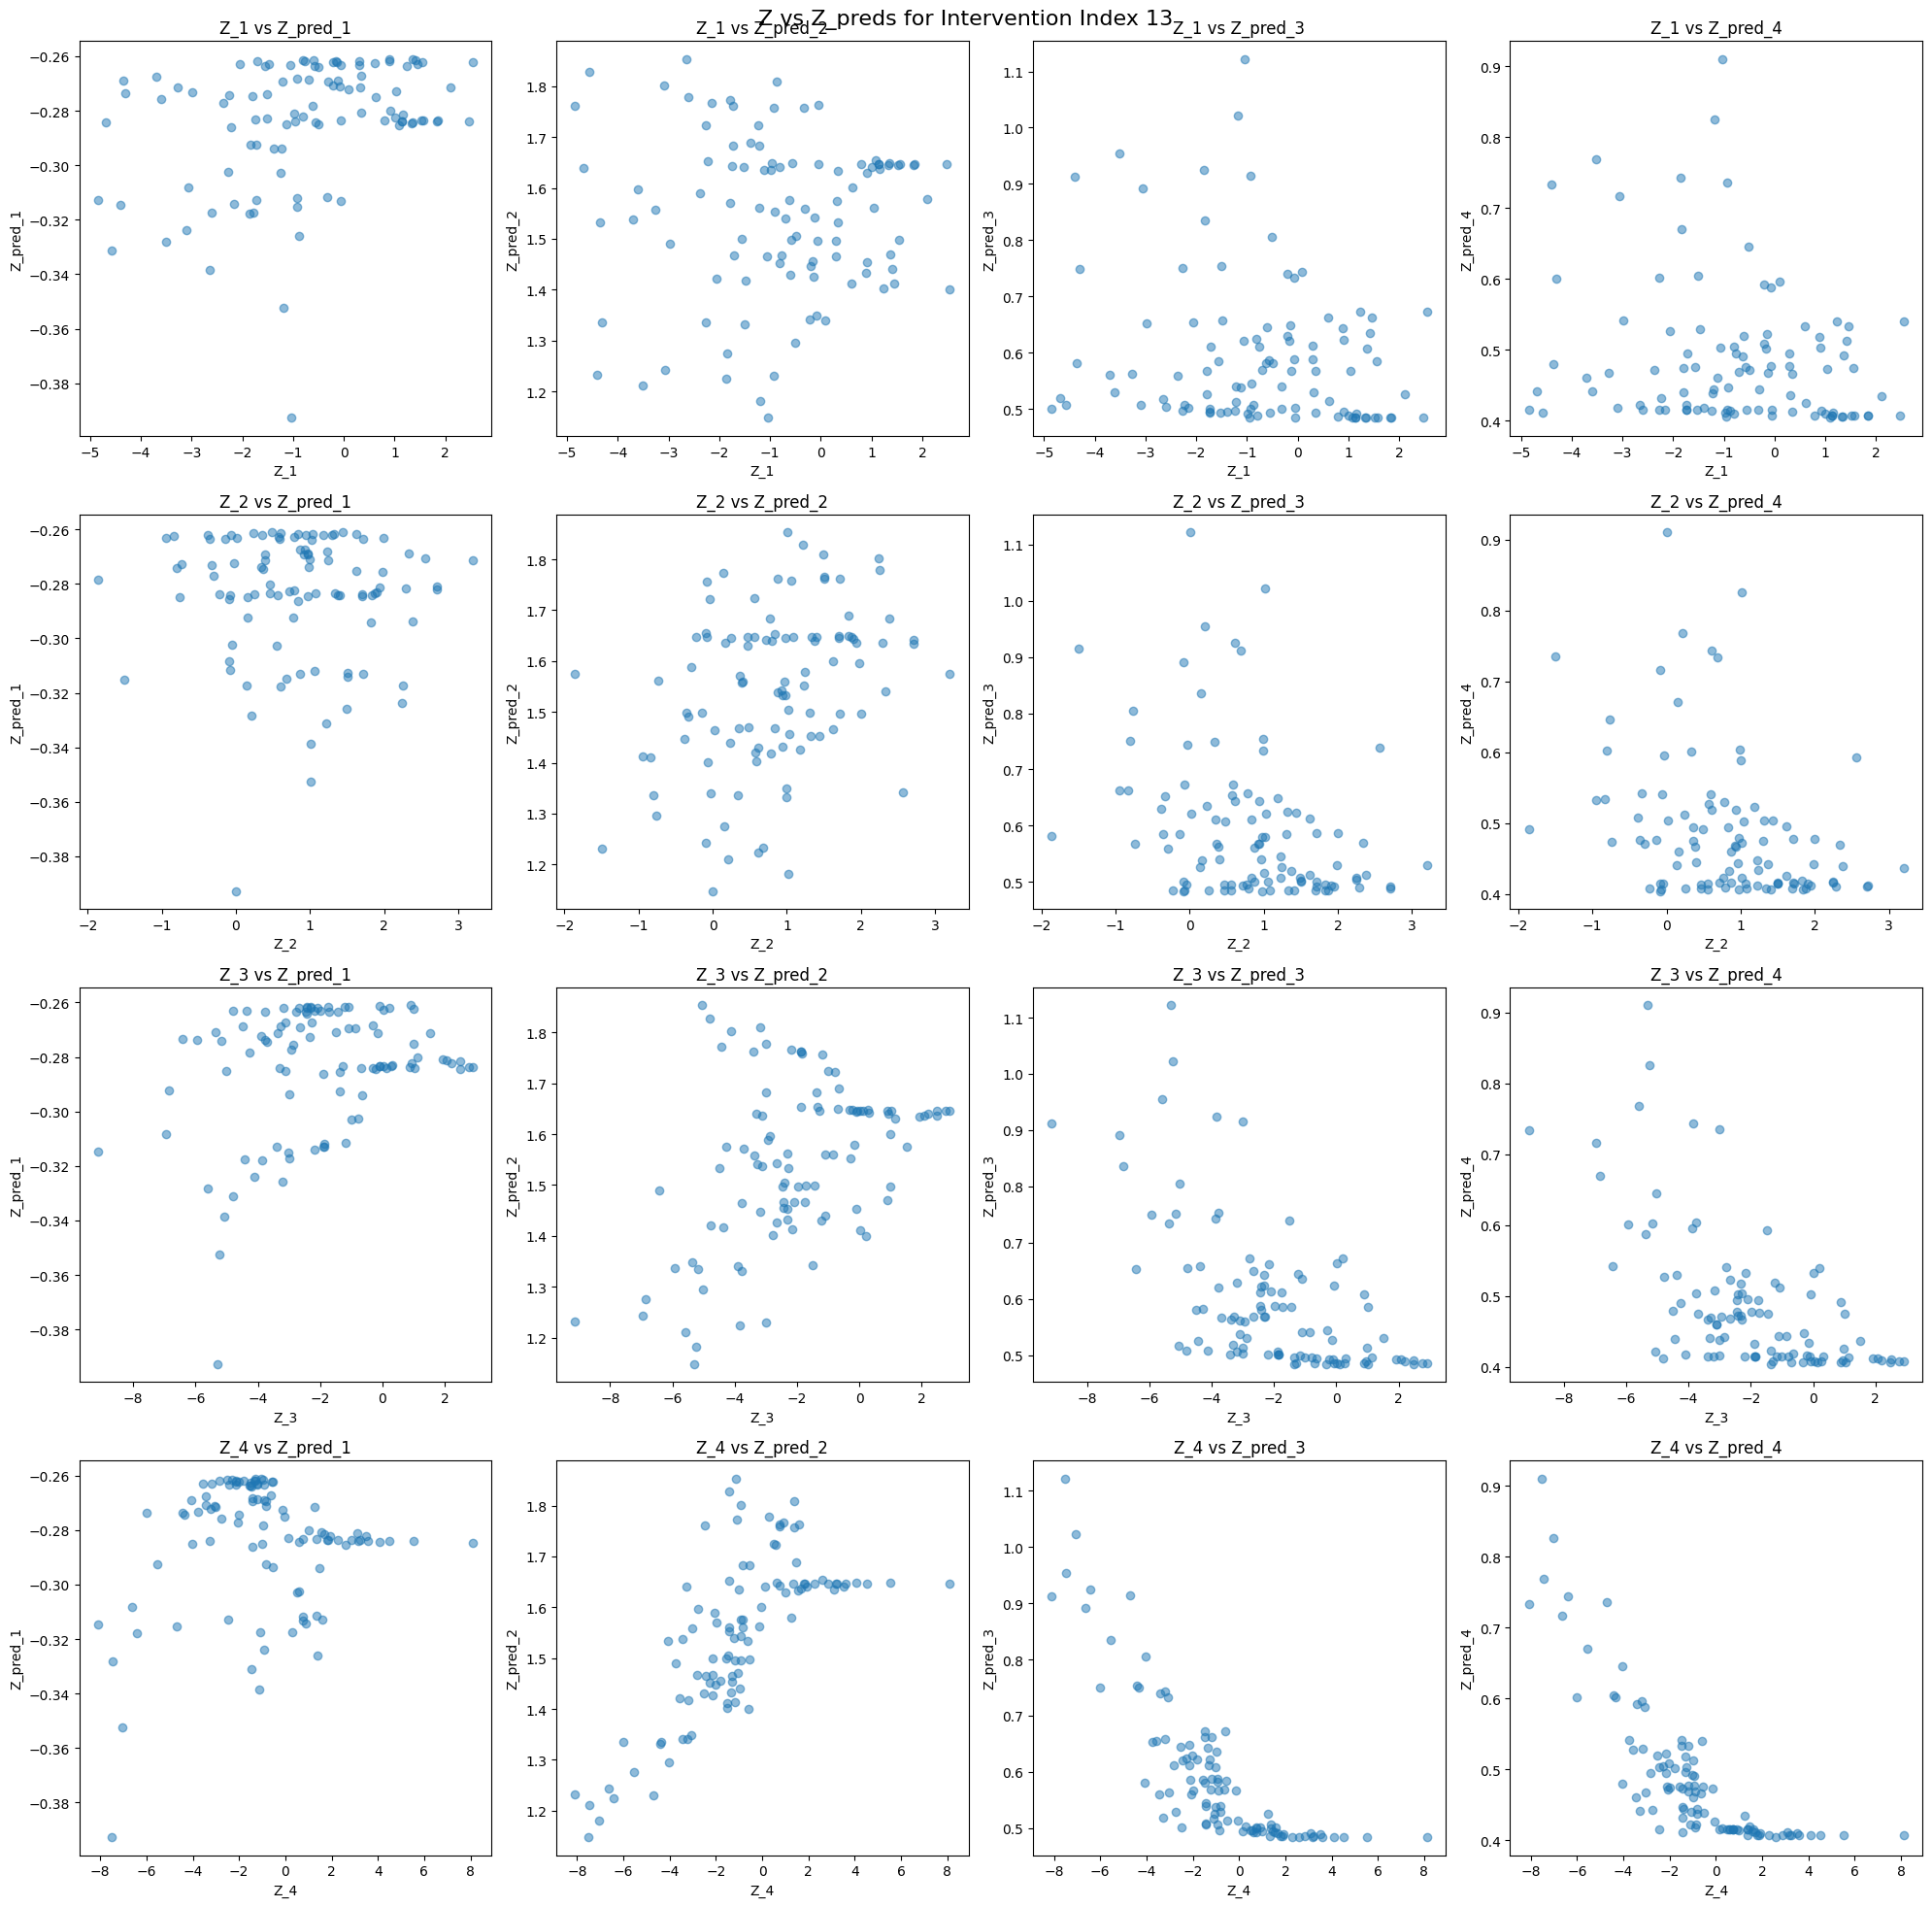

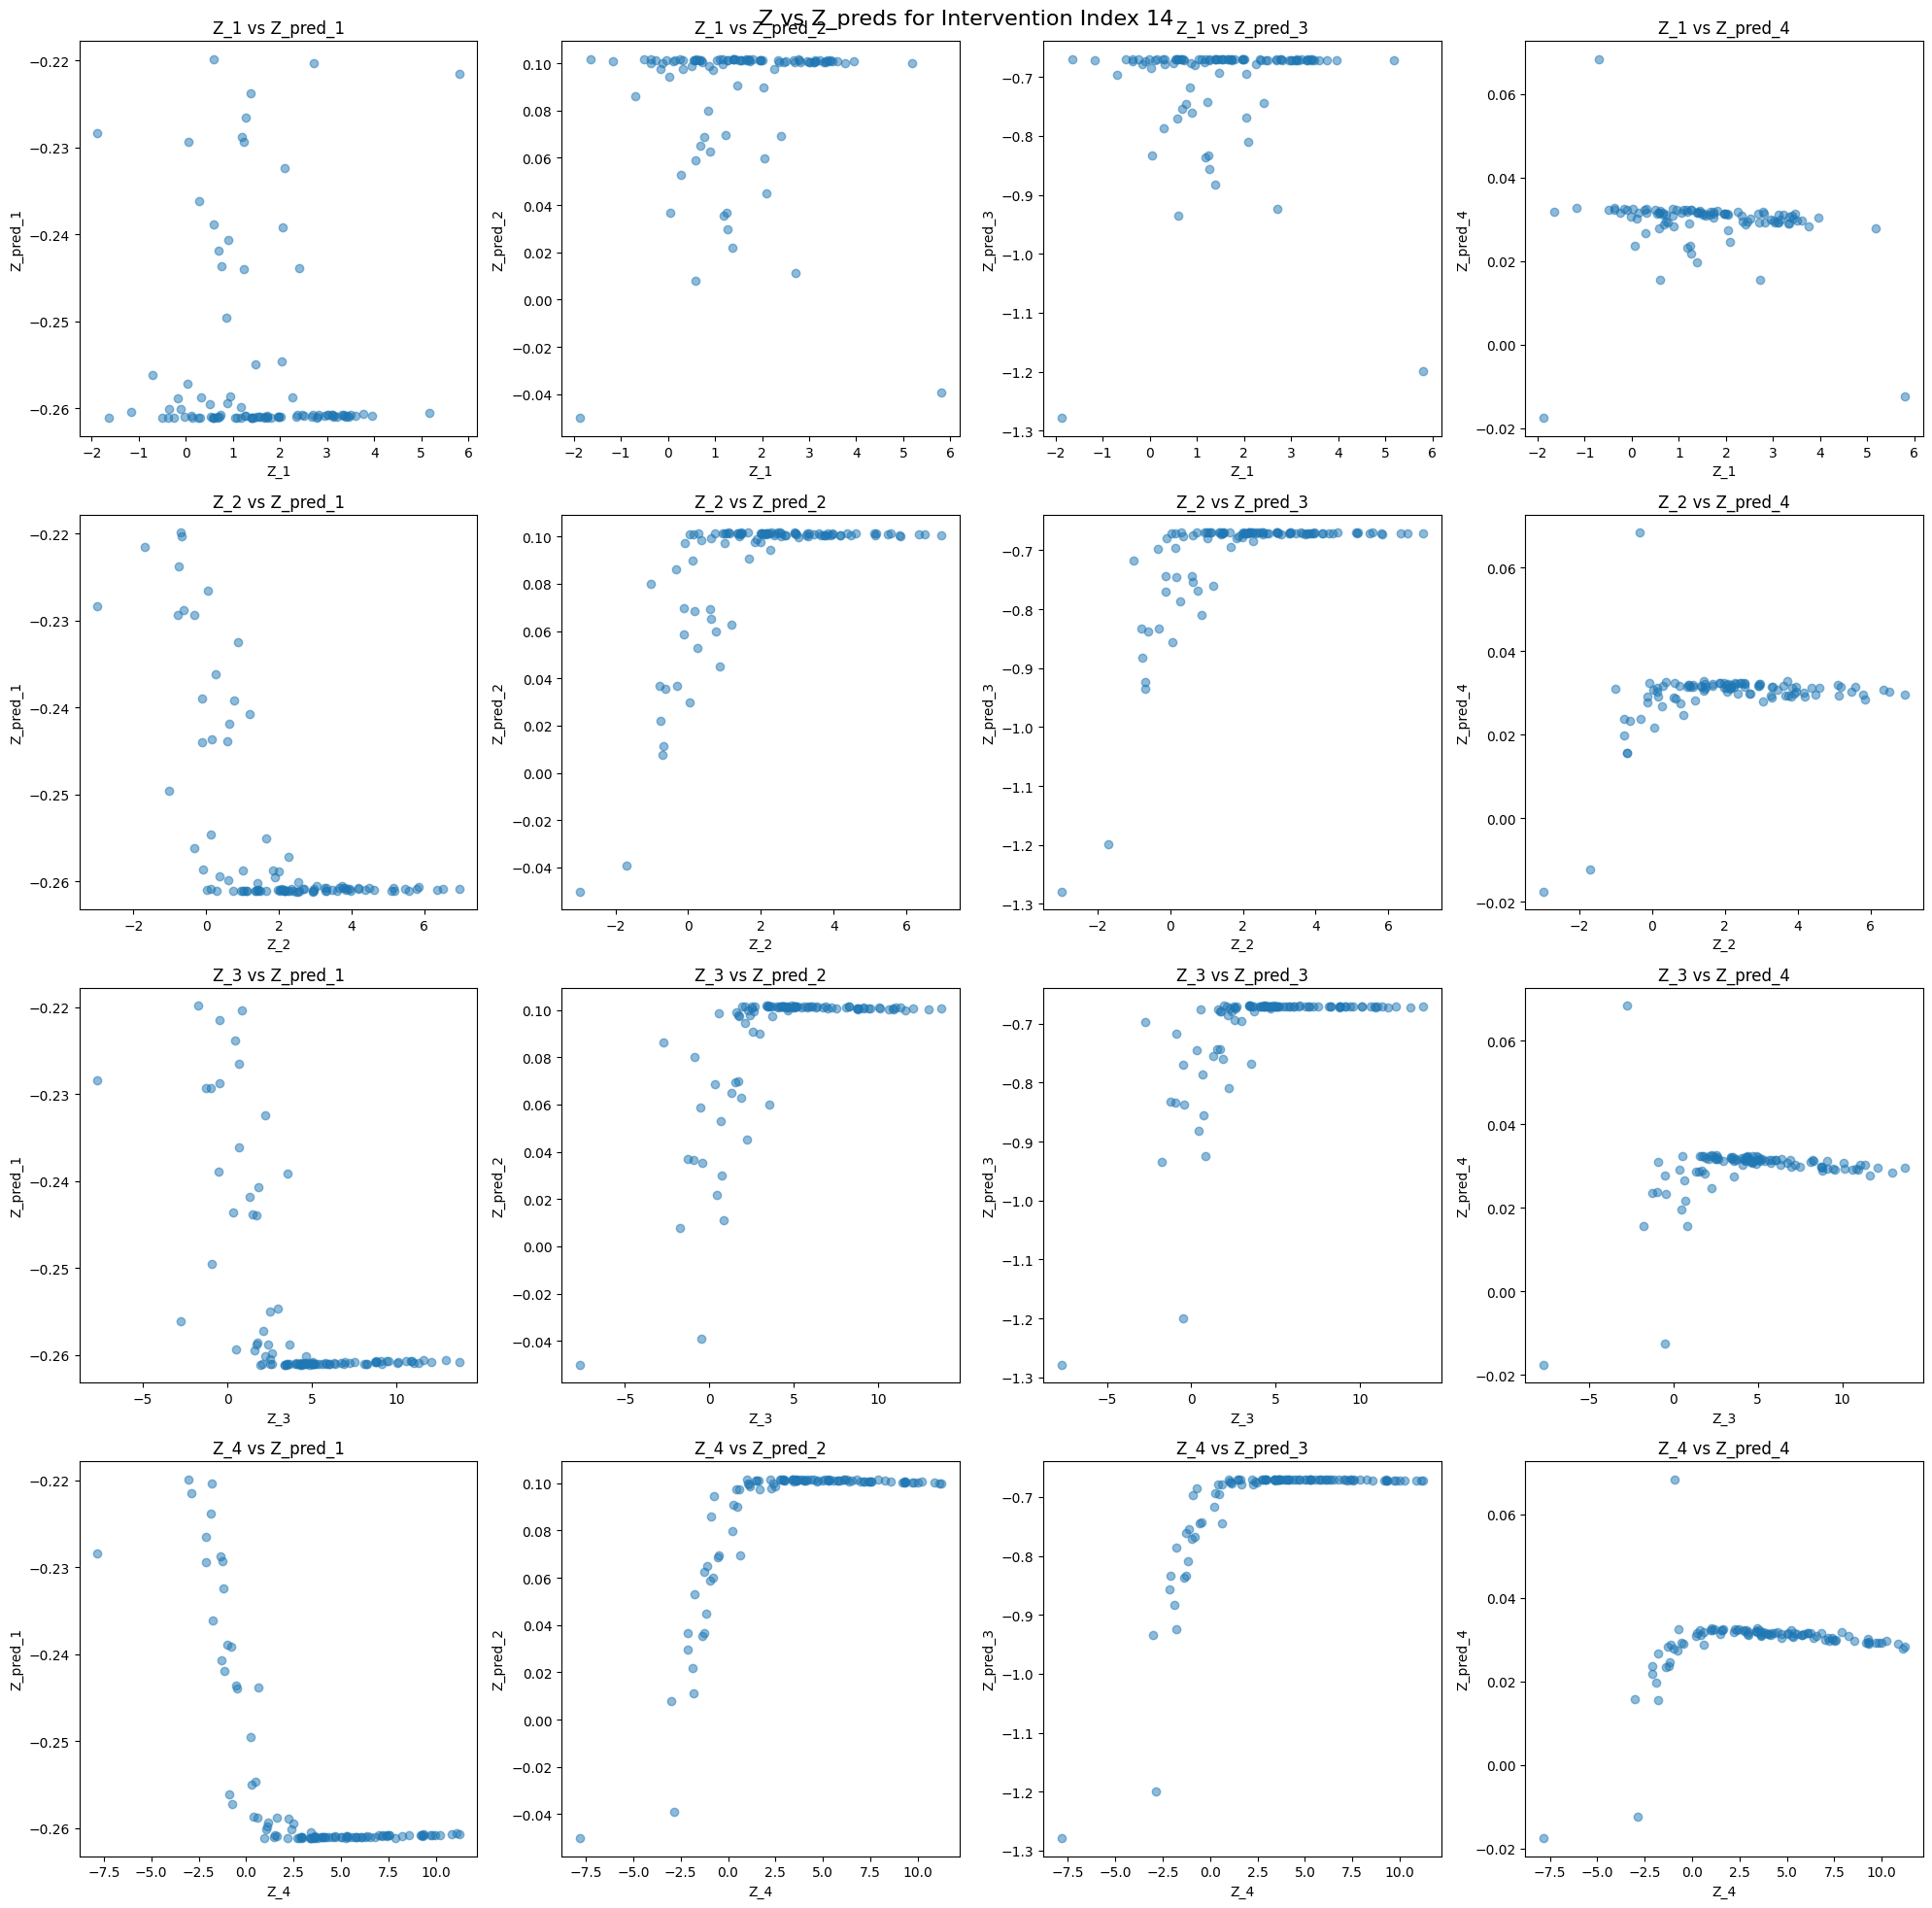

In [9]:
# Get true latent variables, observations, and
# intervention indexes
z, obs, intervention_index = data.tensors

# If using GPU, move data to GPU
if USE_CUDA:
  z = z.cuda()
  obs = obs.cuda()
  intervention_index = intervention_index.cuda()

# Get predictions of latent values for each observation
# from posterior approximation
z_preds = vae.guide(obs, intervention_index)

# Plot true latent variable values versus predicted
# latent variable values for each intervention index
for idx in range(num_interventions):
  # Filter tensors for the current intervention index
  mask = intervention_index == idx
  z_filtered = z[mask]
  z_preds_filtered = z_preds[mask]

  # Convert tensors to CPU and numpy for plotting
  z_filtered = z_filtered.detach().cpu().numpy()
  z_preds_filtered = z_preds_filtered.detach().cpu().numpy()

  # Create a 4x4 grid of subplots
  fig, axs = plt.subplots(4, 4, figsize=(20, 20))
  fig.suptitle(f'Z vs Z_preds for Intervention Index {idx}', fontsize=16)

  for i in range(4):
      for j in range(4):
          axs[i, j].scatter(z_filtered[:, i], z_preds_filtered[:, j], alpha=0.5)
          axs[i, j].set_title(f'Z_{i+1} vs Z_pred_{j+1}')
          axs[i, j].set_xlabel(f'Z_{i+1}')
          axs[i, j].set_ylabel(f'Z_pred_{j+1}')

  plt.tight_layout()
  plt.show()




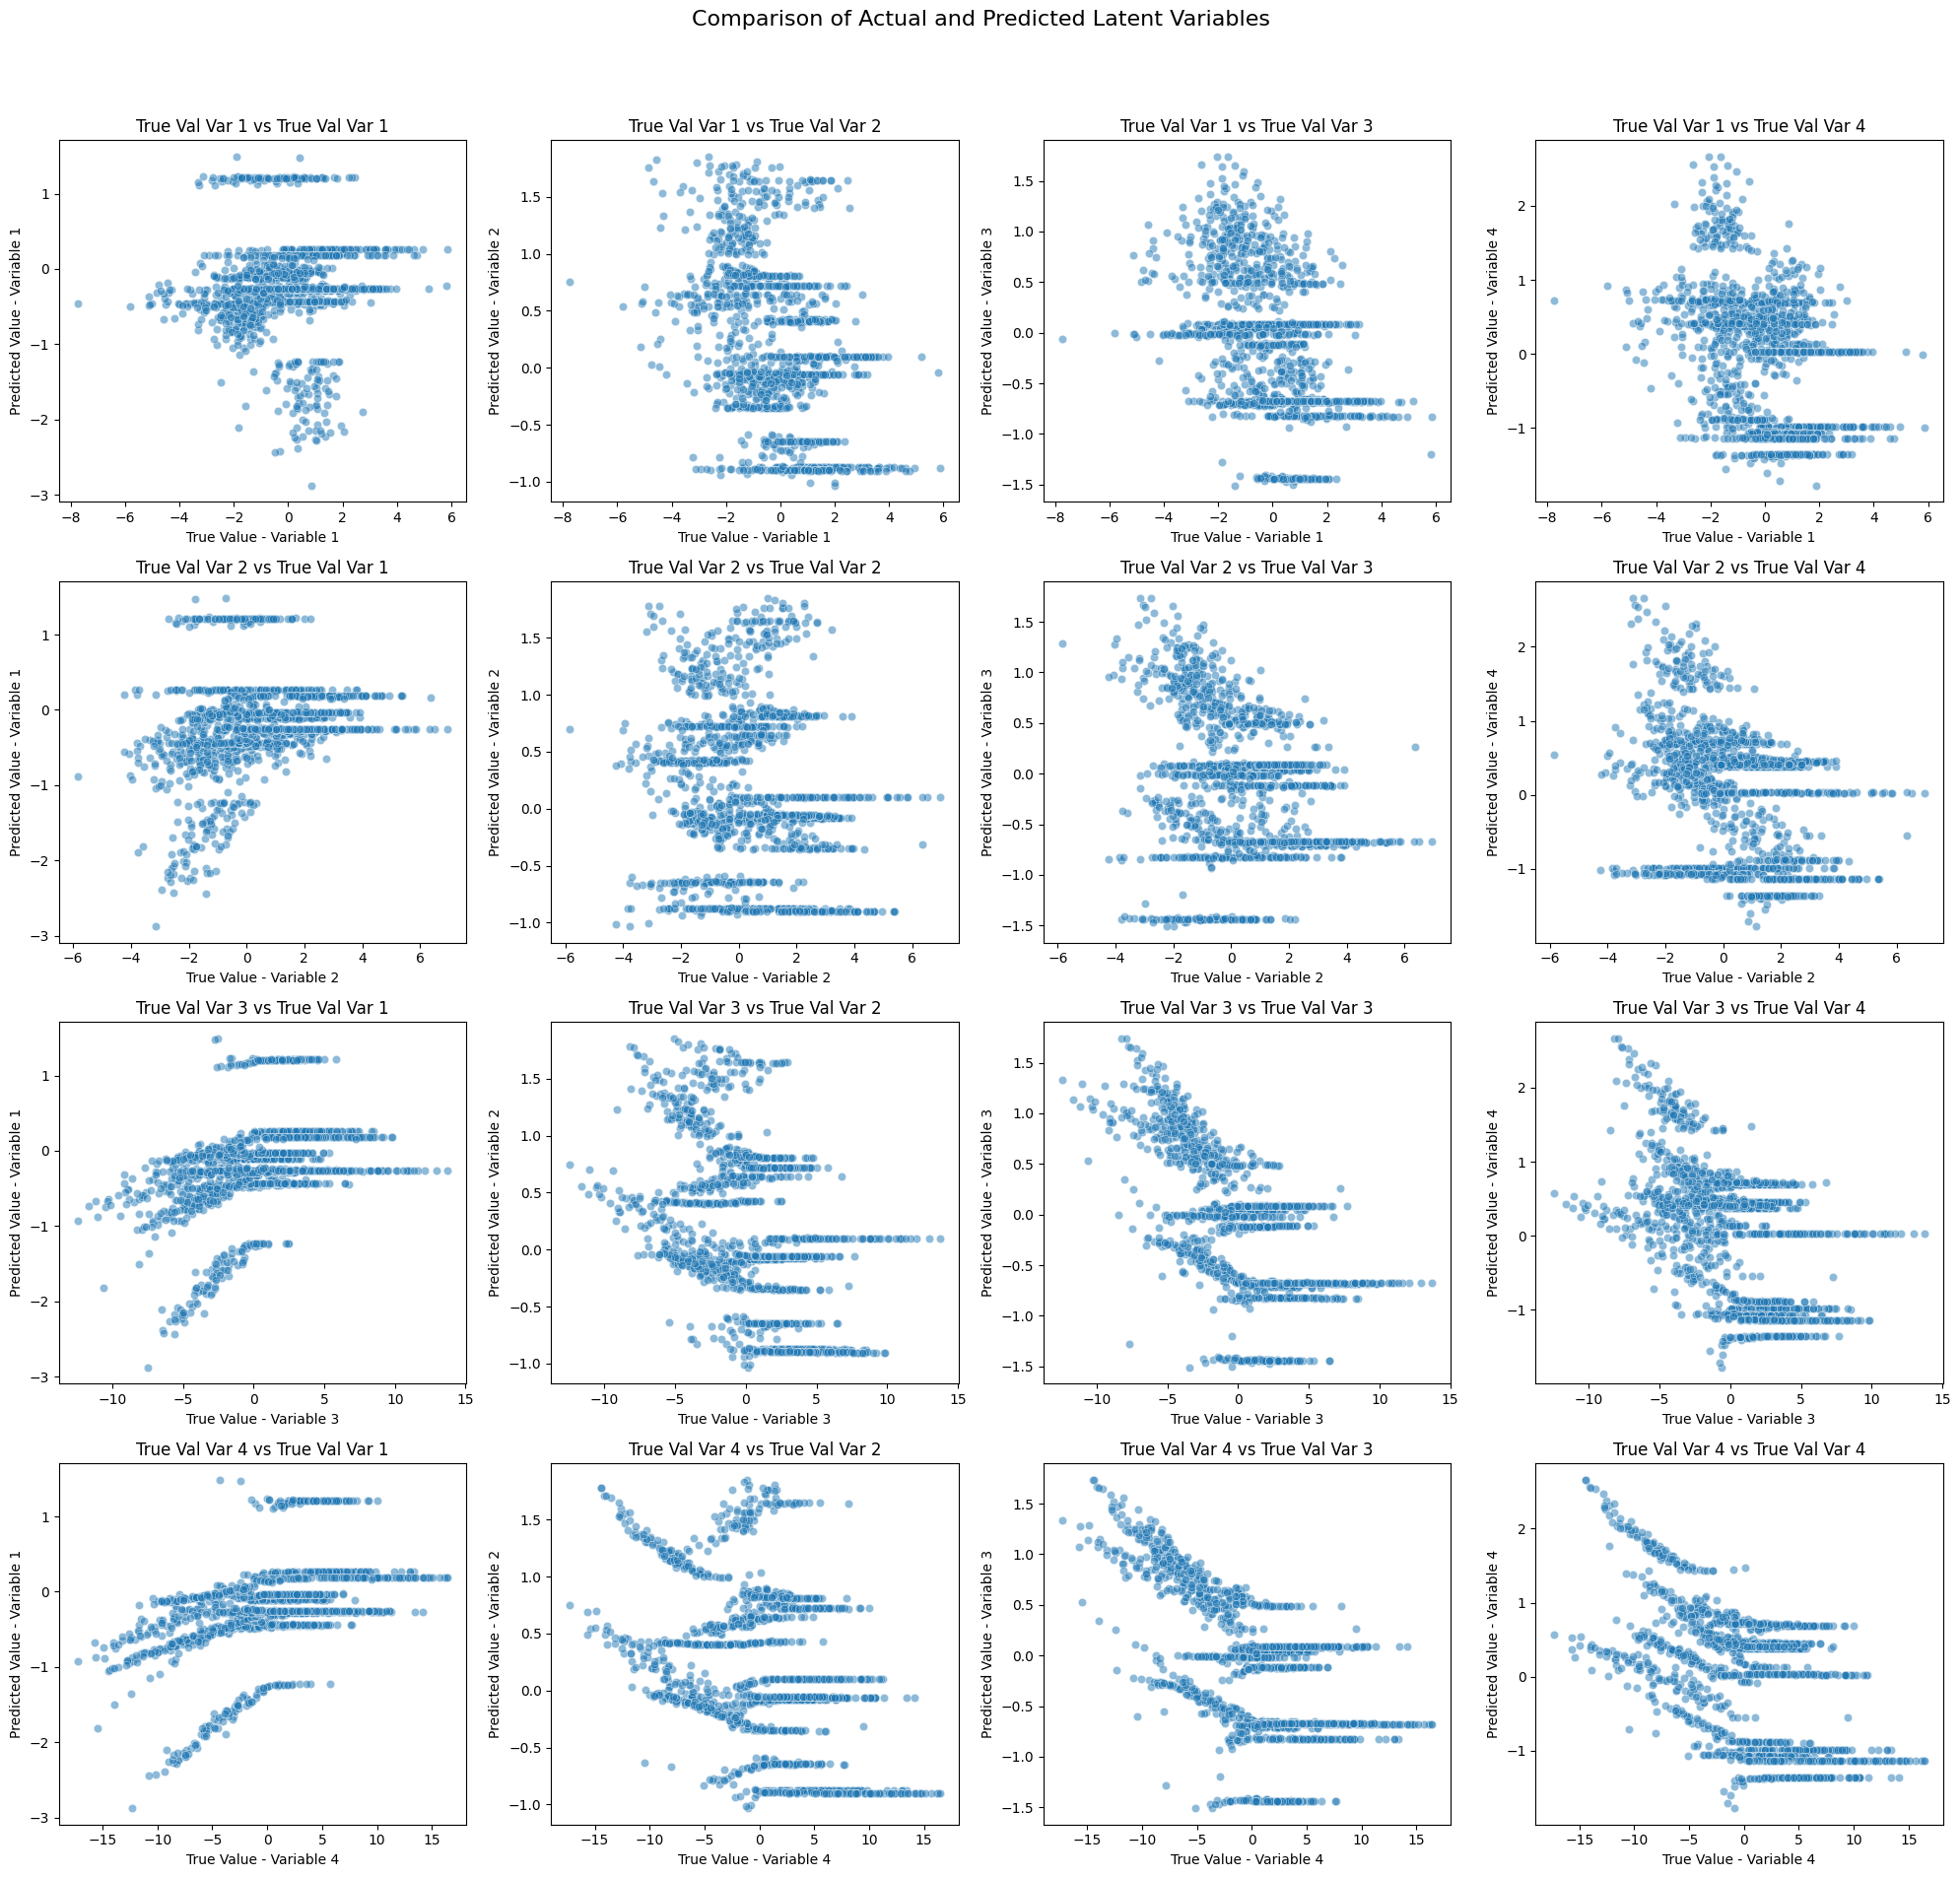

In [10]:
# Move actual and predicted latent variable
# values to CPU and convert to numpy for plotting
z = z.detach().cpu().numpy()
z_preds = z_preds.detach().cpu().numpy()

# Set up the plot grid
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle('Comparison of Actual and Predicted Latent Variables', fontsize=16)

# Flatten the axes array for easier iteration
axs_flat = axs.flatten()

# Create 16 plots
for i in range(4):
    for j in range(4):
        ax = axs_flat[i*4 + j]

        # Plot scatter plot
        # Convert to numpy array if needed
        x = z[:, i]
        y = z_preds[:, j]
        sns.scatterplot(x=x, y=y, ax=ax, alpha=0.5)

        # Set labels
        ax.set_xlabel(f'True Value - Variable {i+1}')
        ax.set_ylabel(f'Predicted Value - Variable {j+1}')

        # Set title
        ax.set_title(f'True Val Var {i+1} vs True Val Var {j+1}')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
param_store = pyro.get_param_store()
print("Parameters in the Pyro parameter store:")
for name, param in param_store.items():
    print(f"Name: {name}")
    print(f"Value: {param.data}")
    print(f"Shape: {param.shape}")
    print(f"Device: {param.device}")
    print("---")

Parameters in the Pyro parameter store:
Name: vae$$$encoders.0.fc1.weight
Value: tensor([[-0.1261,  0.4797,  0.3060,  0.3144],
        [ 0.2305, -0.2138,  0.2983,  0.1615],
        [-0.1810,  0.0430,  0.5637,  0.0187],
        [-0.4780, -0.4311,  0.6025, -0.0567],
        [-0.3478, -0.0205, -0.1541, -0.2489],
        [-0.3448, -0.0365, -0.2588, -0.2143],
        [ 0.2357, -0.4686, -0.0681,  0.4237],
        [-0.2979, -0.4795, -0.3077, -0.2960],
        [ 0.3183, -0.4519,  0.1986, -0.0037],
        [-0.4001, -0.1419, -0.2944,  0.3170],
        [-0.2321,  0.4233, -0.0236,  0.1240],
        [ 0.3885, -0.1786, -0.4755, -0.4940],
        [-0.2911, -0.2875,  0.0983,  0.0248],
        [-0.0365, -0.1232,  0.0575, -0.4204],
        [-0.2912, -0.1651, -0.1075, -0.1773],
        [ 0.2534, -0.0848,  0.0535, -0.4918],
        [-0.0283,  0.3119, -0.4519, -0.4265],
        [ 0.5213,  0.1198,  0.3196, -0.5635],
        [ 0.2309, -0.0981,  0.0641,  0.0949],
        [ 0.3021,  0.0394, -0.2593,  0.1542],